##Import Package

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
import seaborn as sns
import matplotlib.pyplot as plt
import time
!pip install memory_profiler
from memory_profiler import memory_usage
from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules
from collections import defaultdict
import random
import warnings
warnings.filterwarnings('ignore')
!pip install python-docx
import docx
from google.colab import files

In [ ]:
def df_to_word(df, report_name:str, inverse=False) -> docx.Document:
    assert '.docx' in report_name, 'report_name has to be a .docx file'
    doc = docx.Document()
    if not inverse:
        table = doc.add_table(df.shape[0]+1, df.shape[1]+1)
        for i, idx in enumerate(df.index):
            table.cell(i+1,0).text = str(idx)
            table.cell(i+1,0).paragraphs[0].runs[0].font.bold = True
        for i in range(df.shape[-1]):
            table.cell(0,i+1).text = str(df.columns[i])
            table.cell(0,i+1).paragraphs[0].runs[0].font.bold = True
        for i in range(df.shape[0]):
            for j in range(df.shape[-1]):
                table.cell(i+1,j+1).text = str(df.values[i,j])
    else:
        table = doc.add_table(df.shape[1]+1, df.shape[0]+1)
        for i, idx in enumerate(df.index):
            table.cell(0,i+1).text = str(idx)
            table.cell(0,i+1).paragraphs[0].runs[0].font.bold = True
        for i in range(df.shape[-1]):
            table.cell(i+1,0).text = str(df.columns[i])
            table.cell(i+1,0).paragraphs[0].runs[0].font.bold = True
        for i in range(df.shape[0]):
            for j in range(df.shape[-1]):
                table.cell(j+1,i+1).text = str(df.values[i,j])
    table.style = 'Table Grid'
    if df.index.name:
        table.cell(0,0).text = df.index.name
        table.cell(0,0).paragraphs[0].runs[0].font.bold = True
    doc.save(f'./{report_name}')
    files.download(report_name)

##Import Data

In [ ]:
# Load the dataset
link='https://drive.google.com/file/d/1fwBsv-qjYG7wrPn0F5PLM55bECBJRIif/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id='+link.split('/')[-2]
df = pd.read_csv(path, index_col='index')

# View the first few rows of the dataset
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
index,,,,,,,,
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [ ]:
# Get basic information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 37.2+ MB


In [ ]:
# Descriptive statistics for key numerical attributes
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


##EDA & Preprocessing

In [ ]:
# Check for missing values to assess data completeness
missing_values = df.isnull().sum()
print('Missing values in each column:')
missing = pd.DataFrame(missing_values, columns=['Count'])
missing

Missing values in each column:


,Count
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0


In [ ]:
df['CustomerID'] = df['CustomerID'].astype(str)

In [ ]:
# Skewness and Kurtosis for numerical columns
skewness = df.select_dtypes(include=['number']).apply(lambda x: skew(x.dropna()))
kurtosis_vals = df.select_dtypes(include=['number']).apply(lambda x: kurtosis(x.dropna()))
stats_df = pd.DataFrame({'Skewness': skewness, 'Kurtosis': kurtosis_vals})
stats_df

,Skewness,Kurtosis
Quantity,-0.264076,119768.054955
UnitPrice,186.506455,59005.174663


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   541909 non-null  object 
 7   Country      541909 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 37.2+ MB


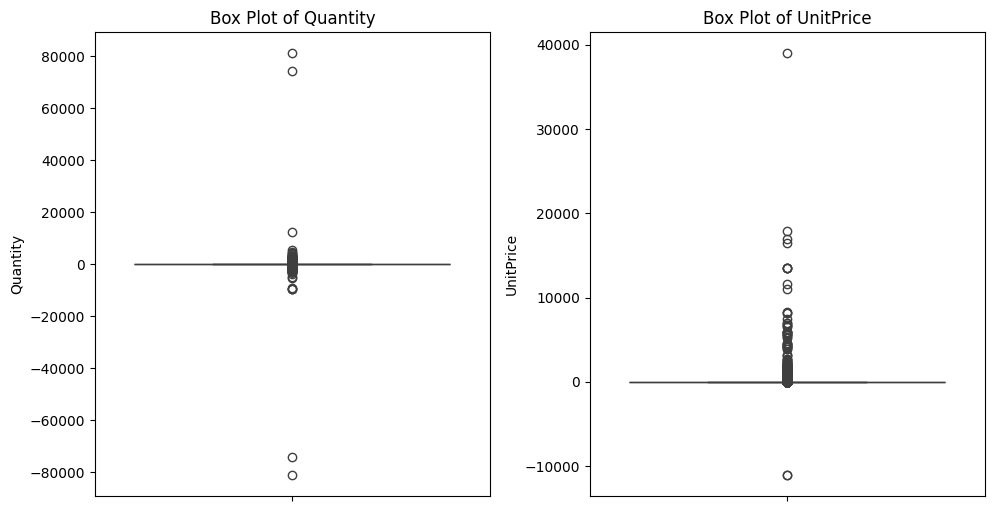

In [ ]:
# Box plot to identify outliers for numerical columns
plt.figure(figsize=(15, 10))
numerical_cols = df.select_dtypes(include=['number']).columns
for i, col in enumerate(numerical_cols):
    plt.subplot(2, 3, i + 1)  # Adjust subplot layout as needed
    sns.boxplot(df[col])
    plt.title(f'Box Plot of {col}')
plt.tight_layout()
plt.show()

In [ ]:
# Identify outliers in Quantity
quantity_outliers = df[(df['Quantity'] < 0) | (df['Quantity'] > df['Quantity'].quantile(0.99))].shape[0]

# Identify outliers in UnitPrice
unitprice_outliers = df[(df['UnitPrice'] < 0) | (df['UnitPrice'] > df['UnitPrice'].quantile(0.99))].shape[0]

# Print the counts of outliers
print(f"Quantity Outliers: {quantity_outliers}")
print(f"UnitPrice Outliers: {unitprice_outliers}")

Quantity Outliers: 15574
UnitPrice Outliers: 4792


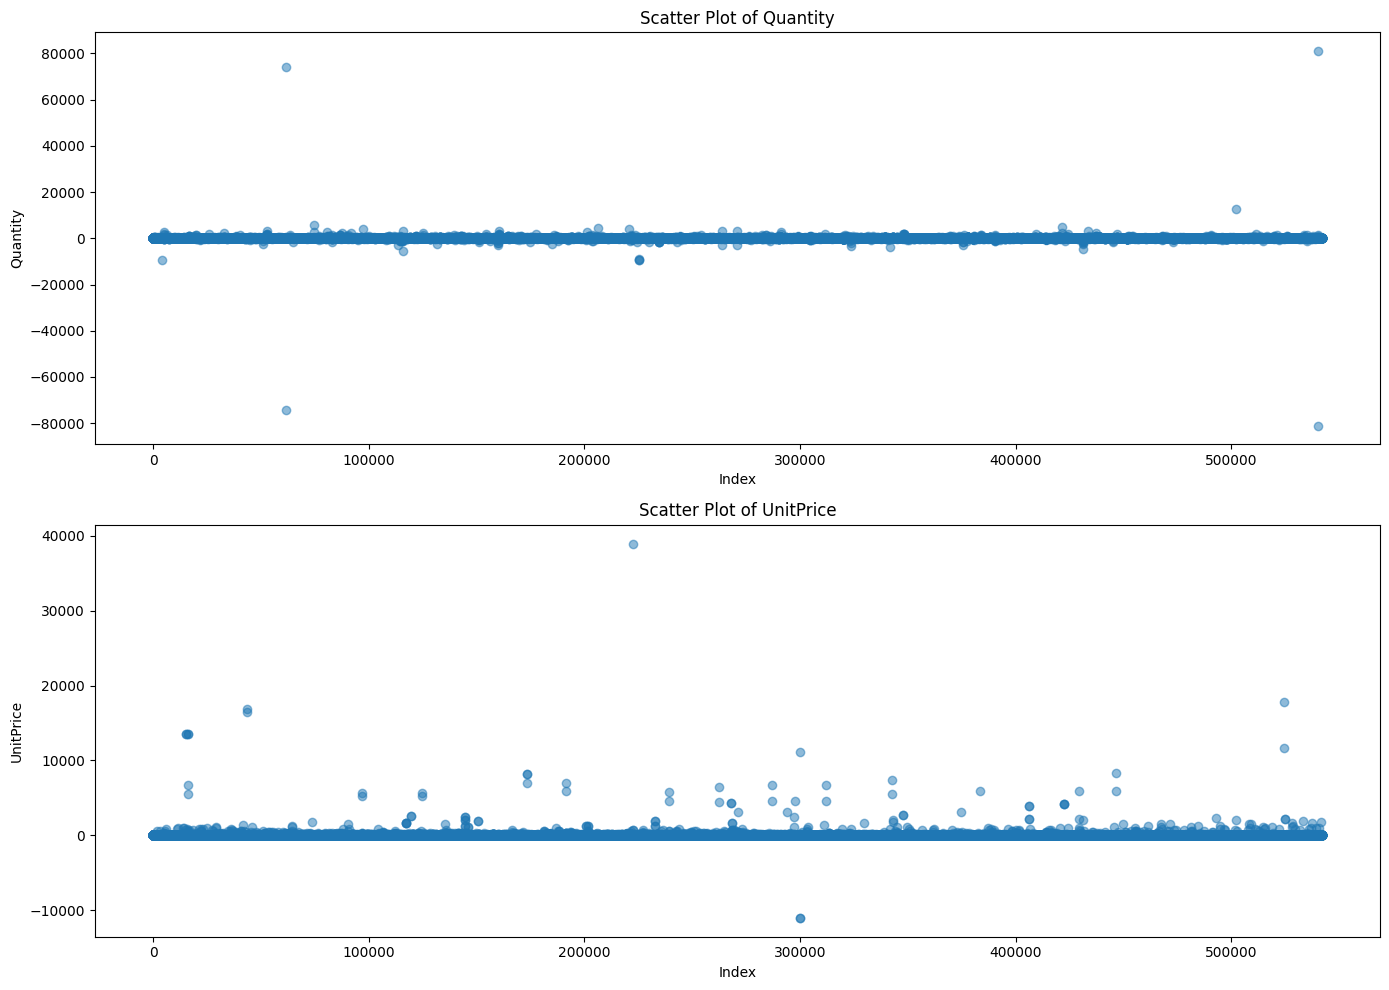

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(14, 10))

axs[0].scatter(df.index, df['Quantity'], alpha=0.5)
axs[0].set_title('Scatter Plot of Quantity')
axs[0].set_xlabel('Index')
axs[0].set_ylabel('Quantity')

axs[1].scatter(df.index, df['UnitPrice'], alpha=0.5)
axs[1].set_title('Scatter Plot of UnitPrice')
axs[1].set_xlabel('Index')
axs[1].set_ylabel('UnitPrice')

plt.tight_layout()
plt.show()

In [ ]:
# Pairwise correlations
numeric_columns = df.select_dtypes(include=['number']).columns
df[numeric_columns].corr()

,Quantity,UnitPrice
Quantity,1.000000,-0.001235
UnitPrice,-0.001235,1.000000


####Check duplicates

In [ ]:
# Identify duplicate rows based on InvoiceNo, CustomerID, StockCode, and Description
duplicates = df[df.duplicated(subset=['InvoiceNo', 'CustomerID', 'StockCode', 'Description'], keep=False)]

# Display the duplicate rows
duplicates

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
index,,,,,,,,
113,536381,71270,PHOTO CLIP LINE,1,12/1/2010 9:41,1.25,15311.0,United Kingdom
125,536381,71270,PHOTO CLIP LINE,3,12/1/2010 9:41,1.25,15311.0,United Kingdom
483,536409,90199C,5 STRAND GLASS NECKLACE CRYSTAL,3,12/1/2010 11:45,6.35,17908.0,United Kingdom
485,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,12/1/2010 11:45,4.95,17908.0,United Kingdom
489,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,12/1/2010 11:45,2.10,17908.0,United Kingdom
...,...,...,...,...,...,...,...,...
541692,581538,22992,REVOLVER WOODEN RULER,1,12/9/2011 11:34,1.95,14446.0,United Kingdom
541697,581538,21194,PINK HONEYCOMB PAPER FAN,1,12/9/2011 11:34,0.65,14446.0,United Kingdom
541698,581538,35004B,SET OF 3 BLACK FLYING DUCKS,1,12/9/2011 11:34,5.45,14446.0,United Kingdom


In [ ]:
df = df.drop_duplicates(subset=['InvoiceNo', 'CustomerID', 'StockCode', 'Description'])

####Handling Misvalue

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 531227 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    531227 non-null  object 
 1   StockCode    531227 non-null  object 
 2   Description  529773 non-null  object 
 3   Quantity     531227 non-null  int64  
 4   InvoiceDate  531227 non-null  object 
 5   UnitPrice    531227 non-null  float64
 6   CustomerID   531227 non-null  object 
 7   Country      531227 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 36.5+ MB


In [ ]:
def get_unique_countries(df):
    """
    Hàm này trả về danh sách các giá trị duy nhất trong cột Country.

    Tham số:
    df (pandas.DataFrame): Dataset chứa cột Country.

    Trả về:
    list: Danh sách các giá trị duy nhất trong cột Country.
    """
    unique_countries = df['Country'].unique()
    return unique_countries

In [ ]:
unique_countries = get_unique_countries(df)
print(f'Danh sách các quốc gia duy nhất trong cột Country: {unique_countries}')

Danh sách các quốc gia duy nhất trong cột Country: ['United Kingdom' 'France' 'Australia' 'Netherlands' 'Germany' 'Norway'
 'EIRE' 'Switzerland' 'Spain' 'Poland' 'Portugal' 'Italy' 'Belgium'
 'Lithuania' 'Japan' 'Iceland' 'Channel Islands' 'Denmark' 'Cyprus'
 'Sweden' 'Austria' 'Israel' 'Finland' 'Bahrain' 'Greece' 'Hong Kong'
 'Singapore' 'Lebanon' 'United Arab Emirates' 'Saudi Arabia'
 'Czech Republic' 'Canada' 'Unspecified' 'Brazil' 'USA'
 'European Community' 'Malta' 'RSA']


In [ ]:
df = df[df['Country'] != 'Unspecified']

In [ ]:
df.isna().sum()

,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,0
Country,0


In [ ]:
df['CustomerID'] = df['CustomerID'].fillna('unknown')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 530794 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    530794 non-null  object 
 1   StockCode    530794 non-null  object 
 2   Description  529340 non-null  object 
 3   Quantity     530794 non-null  int64  
 4   InvoiceDate  530794 non-null  object 
 5   UnitPrice    530794 non-null  float64
 6   CustomerID   530794 non-null  object 
 7   Country      530794 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 36.4+ MB


In [ ]:
df = df.dropna(subset=['Description'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 529340 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    529340 non-null  object 
 1   StockCode    529340 non-null  object 
 2   Description  529340 non-null  object 
 3   Quantity     529340 non-null  int64  
 4   InvoiceDate  529340 non-null  object 
 5   UnitPrice    529340 non-null  float64
 6   CustomerID   529340 non-null  object 
 7   Country      529340 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 36.3+ MB


In [ ]:
df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 519151 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    519151 non-null  object 
 1   StockCode    519151 non-null  object 
 2   Description  519151 non-null  object 
 3   Quantity     519151 non-null  int64  
 4   InvoiceDate  519151 non-null  object 
 5   UnitPrice    519151 non-null  float64
 6   CustomerID   519151 non-null  object 
 7   Country      519151 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 35.6+ MB


####Transform Data

In [ ]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='%m/%d/%Y %H:%M')
df['InvoiceDate'] = df['InvoiceDate'].dt.strftime('%d/%m/%Y')
df['InvoiceDate']=pd.to_datetime(df['InvoiceDate'],dayfirst=True)
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
index,,,,,,,,
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850.0,United Kingdom


In [ ]:
df['Sales'] = df['Quantity'] * df['UnitPrice']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales
index,,,,,,,,,
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850.0,United Kingdom,20.34


In [ ]:
basket = (df[df['Quantity'] > 0]
          .groupby(['InvoiceNo', 'Description'])['Quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('InvoiceNo'))

# Convert to binary format
basket = basket.applymap(lambda x: 1 if x > 0 else 0)
basket.head()

Description,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,I LOVE LONDON MINI RUCKSACK,NINE DRAWER OFFICE TIDY,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,...,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536365,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536366,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536367,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536368,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536369,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
no_zero_count = (basket == 1).sum(axis=0)
print("Number of values that are 0 in each column of basket:", no_zero_count, sep="/n")

Number of values that are 0 in each column of basket:/nDescription
 4 PURPLE FLOCK DINNER CANDLES       38
 50'S CHRISTMAS GIFT BAG LARGE      129
 DOLLY GIRL BEAKER                  174
 I LOVE LONDON MINI BACKPACK         86
 I LOVE LONDON MINI RUCKSACK          1
                                   ... 
ZINC T-LIGHT HOLDER STARS SMALL     274
ZINC TOP  2 DOOR WOODEN SHELF        12
ZINC WILLIE WINKIE  CANDLE STICK    268
ZINC WIRE KITCHEN ORGANISER          16
ZINC WIRE SWEETHEART LETTER TRAY     23
Length: 4026, dtype: int64


In [ ]:
zero_count = (basket == 0).sum(axis=0)
print("Number of values that are 0 in each column of basket:", zero_count, sep="/n")

Number of values that are 0 in each column of basket:/nDescription
 4 PURPLE FLOCK DINNER CANDLES      19908
 50'S CHRISTMAS GIFT BAG LARGE      19817
 DOLLY GIRL BEAKER                  19772
 I LOVE LONDON MINI BACKPACK        19860
 I LOVE LONDON MINI RUCKSACK        19945
                                    ...  
ZINC T-LIGHT HOLDER STARS SMALL     19672
ZINC TOP  2 DOOR WOODEN SHELF       19934
ZINC WILLIE WINKIE  CANDLE STICK    19678
ZINC WIRE KITCHEN ORGANISER         19930
ZINC WIRE SWEETHEART LETTER TRAY    19923
Length: 4026, dtype: int64


In [ ]:
# pink_pallete = ['#ffe5ec', '#ffc2d1', '#ffb3c6', '#ff8fab', '#fb6f92', '#a63f52', '#f2c2cf', '#f26398', '#d99cb2', '#bbedf2']
# plt.figure(figsize=(12, 3))
# plt.bar(pink_pallete, [1]*len(pink_pallete), align='center', color=pink_pallete)
# plt.show()

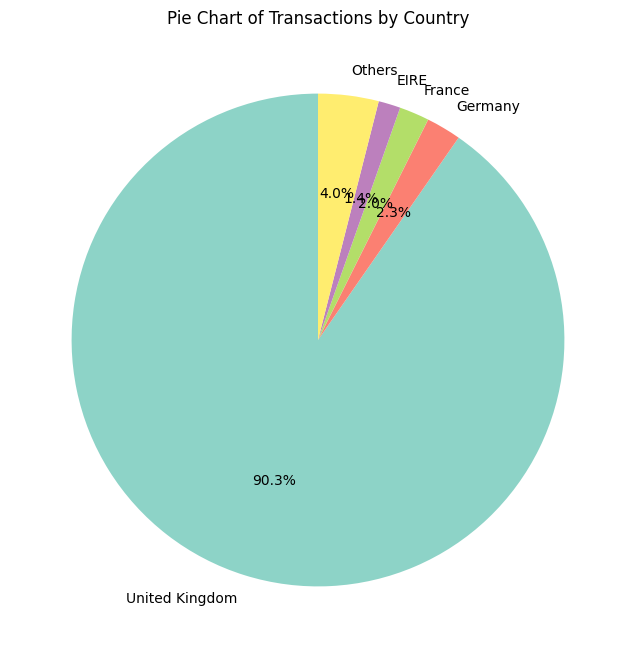

In [ ]:
transactions_per_country = df.groupby('Country')['InvoiceNo'].nunique().sort_values(ascending=False)

# Tính tỷ lệ phần trăm của mỗi quốc gia
percentage_per_country = transactions_per_country / transactions_per_country.sum() * 100

# Nhóm các quốc gia có tỷ lệ phần trăm <= 1% vào danh mục "Others"
threshold = 1  # Ngưỡng tỷ lệ phần trăm
others = percentage_per_country[percentage_per_country <= threshold].sum()
main_countries = percentage_per_country[percentage_per_country > threshold]

# Thêm danh mục "Others" vào danh sách
main_countries['Others'] = others

# Vẽ pie chart
plt.figure(figsize=(10, 8))
main_countries.plot(kind='pie', autopct='%1.1f%%', startangle=90, colormap='Set3')

plt.title('Pie Chart of Transactions by Country')
plt.ylabel('')  # Ẩn nhãn của trục y
plt.show()

In [ ]:
from scipy.interpolate import interp1d
def smooth(x, y):
    f_cubic = interp1d(x, y, kind='cubic')
    xnew = np.linspace(0, len(x)-1, num=101, endpoint=True)
    return xnew, f_cubic(xnew)

In [ ]:
colors = ["#003366", "#CC0000", "#660066", "#FFCC00", "#FF007F", "#004d00", "#FF6600", "#003366", "#4d2a1d", "#333333", "#8B4513", "#6A5ACD", "#8B0000"]

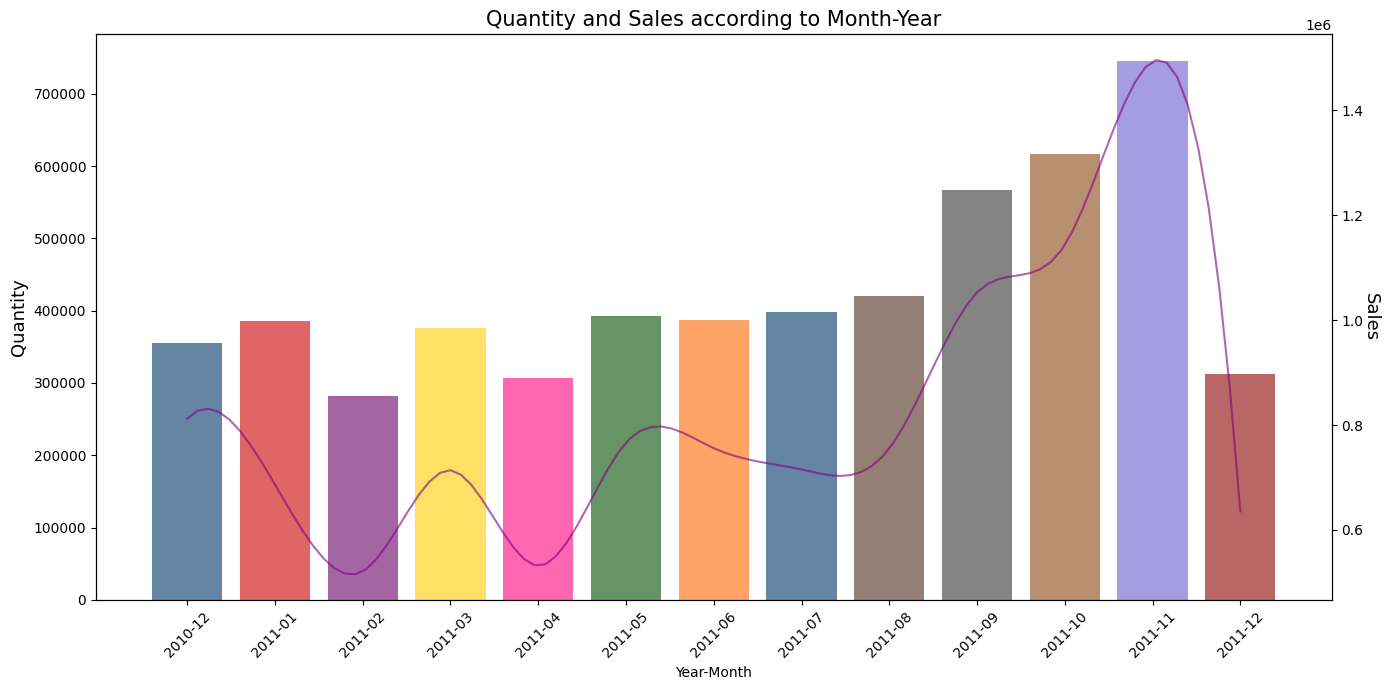

In [ ]:
# Tạo cột Month và Year
df['YearMonth'] = df['InvoiceDate'].dt.to_period('M')

# Tính tổng quantity và sales theo YearMonth
monthly_sales_quantity = df.groupby('YearMonth').agg({'Quantity': 'sum', 'Sales': 'sum'}).reset_index()

# Vẽ biểu đồ
fig, ax1 = plt.subplots(figsize=(14, 7))

# Vẽ cột quantity
ax1.bar(monthly_sales_quantity['YearMonth'].astype(str), monthly_sales_quantity['Quantity'], color = colors
, alpha=0.6, label='Quantity')
ax1.set_xlabel('Year-Month')
ax1.set_ylabel('Quantity', fontsize=13)
ax1.tick_params(axis='x', rotation=45)

# Vẽ cột sales
ax2 = ax1.twinx()
xnew, ynew = smooth(range(len(monthly_sales_quantity['YearMonth'])), monthly_sales_quantity['Sales'])
ax2.plot(xnew, ynew, color='purple', alpha=0.6, label='Sales')
ax2.set_ylabel('Sales', rotation = -90, labelpad=12, fontsize=13)

# Hiển thị biểu đồ
plt.title('Quantity and Sales according to Month-Year', fontsize=15)
fig.tight_layout()
plt.show()

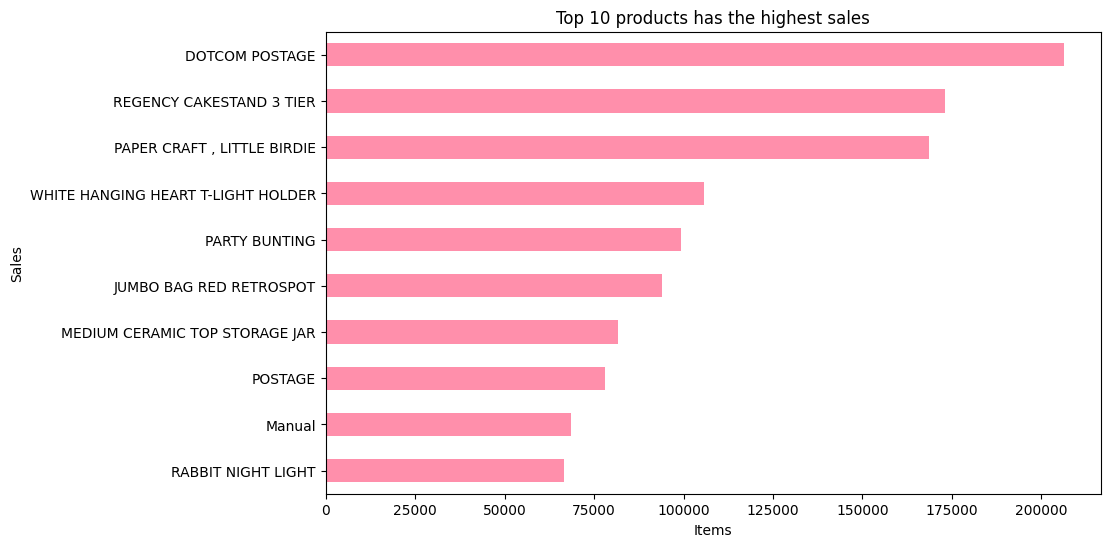

In [ ]:
product_sales = df.groupby('Description')['Sales'].sum().nlargest(10).sort_values(ascending=True)

plt.figure(figsize=(10, 6))
product_sales.plot(kind='barh', color= "#ff8fab")
plt.title('Top 10 products has the highest sales')
plt.xlabel('Items')
plt.ylabel('Sales')
plt.show()

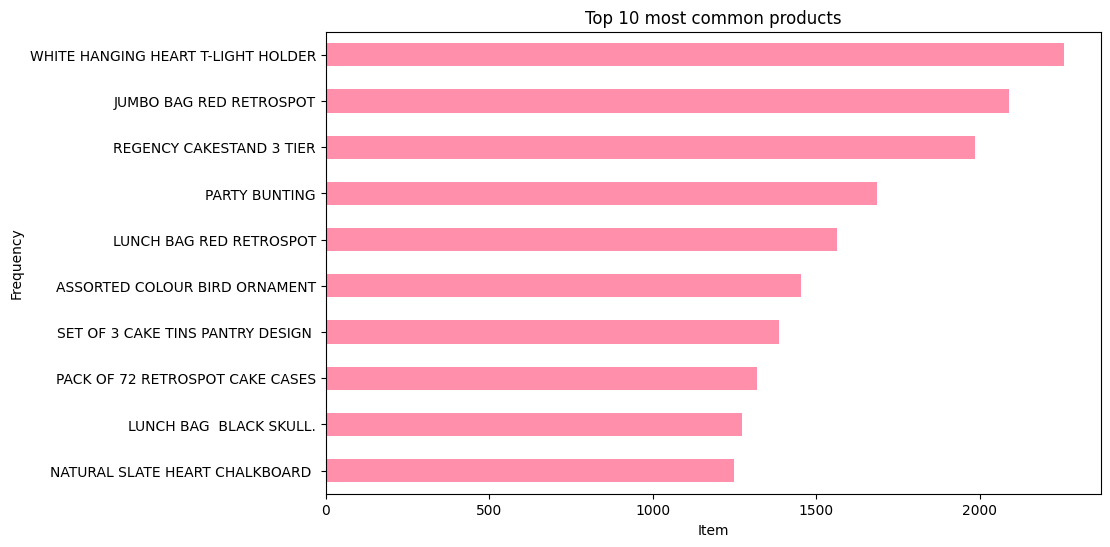

In [ ]:
product_frequency = df['Description'].value_counts().nlargest(10).sort_values(ascending=True)
plt.figure(figsize=(10, 6))
product_frequency.plot(kind='barh', color="#ff8fab")
plt.title('Top 10 most common products')
plt.xlabel('Item')
plt.ylabel('Frequency')
plt.show()

##Algorithm

####Define function

In [ ]:
def find_optimal_min_support(basket, algorithm, min_support_values, low_memory = False):
    results = {}
    for min_support in min_support_values:
        mem_usage_before = memory_usage()[0]
        if algorithm == apriori:
            if not low_memory and min_support < 0.03: continue
            mem_usage_after = max(memory_usage((algorithm, (basket,), {"min_support":min_support, "use_colnames": True, "low_memory": low_memory})))
            start_time = time.time()  # Count time
            frequent_itemsets = algorithm(basket, min_support=min_support, use_colnames=True, low_memory=low_memory)
        else:
            mem_usage_after = max(memory_usage((algorithm, (basket,), {"min_support":min_support, "use_colnames": True})))
            start_time = time.time()  # Count time
            frequent_itemsets = algorithm(basket, min_support=min_support, use_colnames=True)
        elapsed_time = time.time() - start_time
        mem_usage = mem_usage_after - mem_usage_before
        results[min_support] = (len(frequent_itemsets), elapsed_time, mem_usage)
    return results

In [ ]:
def plot_metrics_relationship(rules, col1, col2):
    """
    Biểu đồ thể hiện sự tương quan của các metrics
    """
    fit = np.polyfit(rules[col1], rules[col2], 1)
    fit_funt = np.poly1d(fit)
    plt.plot(rules[col1], rules[col2], 'o', rules[col1], fit_funt(rules[col1]))
    plt.xlabel(col1)
    plt.ylabel(col2)
    plt.title('{} vs {}'.format(col1, col2))

In [ ]:
min_support_values = [i/100 for i in range(1,11)]
print("Apriori:")
apriori_results = find_optimal_min_support(basket, apriori, min_support_values)
# print("  Min Support vs Number of Frequent Itemsets and Time Taken")
for min_support, (count, elapsed_time, memory) in apriori_results.items():
    print(f"Min Support: {min_support}, Number of Frequent Itemsets: {count}, Time Taken: {elapsed_time:.2f} seconds, Memory Used: {memory:.2f} MiB")

Apriori:
Min Support: 0.03, Number of Frequent Itemsets: 141, Time Taken: 2.92 seconds, Memory Used: 2671.69 MiB
Min Support: 0.04, Number of Frequent Itemsets: 67, Time Taken: 1.73 seconds, Memory Used: 652.89 MiB
Min Support: 0.05, Number of Frequent Itemsets: 33, Time Taken: 1.47 seconds, Memory Used: 0.00 MiB
Min Support: 0.06, Number of Frequent Itemsets: 12, Time Taken: 1.78 seconds, Memory Used: 0.00 MiB
Min Support: 0.07, Number of Frequent Itemsets: 6, Time Taken: 1.39 seconds, Memory Used: 0.00 MiB
Min Support: 0.08, Number of Frequent Itemsets: 4, Time Taken: 1.40 seconds, Memory Used: 0.00 MiB
Min Support: 0.09, Number of Frequent Itemsets: 3, Time Taken: 1.29 seconds, Memory Used: 0.00 MiB
Min Support: 0.1, Number of Frequent Itemsets: 2, Time Taken: 1.68 seconds, Memory Used: 0.00 MiB


In [ ]:
print("Apriori w. Low Memory:")
apriori_wlm_results = find_optimal_min_support(basket, apriori, min_support_values, low_memory=True)
print("  Min Support vs Number of Frequent Itemsets and Time Taken")
for min_support, (count, elapsed_time, memory) in apriori_wlm_results.items():
    print(f"Min Support: {min_support}, Number of Frequent Itemsets: {count}, Time Taken: {elapsed_time:.2f} seconds, Memory Used: {memory:.2f} MiB")

Apriori w. Low Memory:
  Min Support vs Number of Frequent Itemsets and Time Taken
Min Support: 0.01, Number of Frequent Itemsets: 1899, Time Taken: 48.33 seconds, Memory Used: 0.00 MiB
Min Support: 0.02, Number of Frequent Itemsets: 379, Time Taken: 18.64 seconds, Memory Used: 0.12 MiB
Min Support: 0.03, Number of Frequent Itemsets: 141, Time Taken: 9.77 seconds, Memory Used: 0.00 MiB
Min Support: 0.04, Number of Frequent Itemsets: 67, Time Taken: 6.13 seconds, Memory Used: 0.00 MiB
Min Support: 0.05, Number of Frequent Itemsets: 33, Time Taken: 4.12 seconds, Memory Used: 0.00 MiB
Min Support: 0.06, Number of Frequent Itemsets: 12, Time Taken: 2.57 seconds, Memory Used: 0.00 MiB
Min Support: 0.07, Number of Frequent Itemsets: 6, Time Taken: 2.28 seconds, Memory Used: 0.00 MiB
Min Support: 0.08, Number of Frequent Itemsets: 4, Time Taken: 1.87 seconds, Memory Used: 0.00 MiB
Min Support: 0.09, Number of Frequent Itemsets: 3, Time Taken: 1.83 seconds, Memory Used: 0.00 MiB
Min Support: 0

In [ ]:
print("FP Growth:")
fpgrowth_results = find_optimal_min_support(basket, fpgrowth, min_support_values)
print("  Min Support vs Number of Frequent Itemsets and Time Taken")
for min_support, (count, elapsed_time, memory) in fpgrowth_results.items():
    print(f"Min Support: {min_support}, Number of Frequent Itemsets: {count}, Time Taken: {elapsed_time:.2f} seconds, Memory Used: {memory:.2f} MiB")

FP Growth:
  Min Support vs Number of Frequent Itemsets and Time Taken
Min Support: 0.01, Number of Frequent Itemsets: 1899, Time Taken: 14.60 seconds, Memory Used: 114.30 MiB
Min Support: 0.02, Number of Frequent Itemsets: 379, Time Taken: 6.51 seconds, Memory Used: 20.33 MiB
Min Support: 0.03, Number of Frequent Itemsets: 141, Time Taken: 4.59 seconds, Memory Used: 0.02 MiB
Min Support: 0.04, Number of Frequent Itemsets: 67, Time Taken: 3.11 seconds, Memory Used: 0.00 MiB
Min Support: 0.05, Number of Frequent Itemsets: 33, Time Taken: 2.82 seconds, Memory Used: 0.00 MiB
Min Support: 0.06, Number of Frequent Itemsets: 12, Time Taken: 2.72 seconds, Memory Used: 0.00 MiB
Min Support: 0.07, Number of Frequent Itemsets: 6, Time Taken: 2.95 seconds, Memory Used: 0.00 MiB
Min Support: 0.08, Number of Frequent Itemsets: 4, Time Taken: 2.58 seconds, Memory Used: 0.00 MiB
Min Support: 0.09, Number of Frequent Itemsets: 3, Time Taken: 2.80 seconds, Memory Used: 0.00 MiB
Min Support: 0.1, Number

####APRIORI

In [ ]:
min_support = 0.01
frequent_itemsets_apriori = apriori(basket, min_support=min_support, use_colnames=True, low_memory=True)
print(f"\nFrequent Itemsets (min_support={min_support}):")
frequent_itemsets_apriori


Frequent Itemsets (min_support=0.01):


,support,itemsets
0,0.013486,( SET 2 TEA TOWELS I LOVE LONDON )
1,0.015943,(10 COLOUR SPACEBOY PEN)
2,0.012534,(12 MESSAGE CARDS WITH ENVELOPES)
3,0.017748,(12 PENCIL SMALL TUBE WOODLAND)
4,0.018099,(12 PENCILS SMALL TUBE RED RETROSPOT)
...,...,...
1894,0.011130,"(JUMBO STORAGE BAG SUKI, JUMBO SHOPPER VINTAGE..."
1895,0.011280,"(LUNCH BAG BLACK SKULL., LUNCH BAG PINK POLKA..."
1896,0.010378,"(LUNCH BAG BLACK SKULL., LUNCH BAG SUKI DESIG..."
1897,0.010278,"(LUNCH BAG BLACK SKULL., LUNCH BAG SUKI DESIG..."


In [ ]:
def find_optimal_min_threshold(frequent_itemsets, min_confidence_values):
    results = {}
    for min_confidence in min_confidence_values:
        start_time = time.time()  # Bắt đầu đo thời gian
        rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_confidence)
        elapsed_time = time.time() - start_time  # Kết thúc đo thời gian
        results[min_confidence] = (len(rules), elapsed_time)
    return results

min_confidence_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
results = find_optimal_min_threshold(frequent_itemsets_apriori, min_confidence_values)

print("\nMin Confidence vs Number of Association Rules and Time Taken")
for min_threshold, (count, elapsed_time) in results.items():
    print(f"Min Confidence: {min_threshold}, Number of Association Rules: {count}, Time Taken: {elapsed_time:.2f} seconds")


Min Confidence vs Number of Association Rules and Time Taken
Min Confidence: 0.1, Number of Association Rules: 3299, Time Taken: 0.02 seconds
Min Confidence: 0.2, Number of Association Rules: 2699, Time Taken: 0.02 seconds
Min Confidence: 0.3, Number of Association Rules: 1822, Time Taken: 0.01 seconds
Min Confidence: 0.4, Number of Association Rules: 1300, Time Taken: 0.01 seconds
Min Confidence: 0.5, Number of Association Rules: 895, Time Taken: 0.01 seconds
Min Confidence: 0.6, Number of Association Rules: 538, Time Taken: 0.01 seconds
Min Confidence: 0.7, Number of Association Rules: 289, Time Taken: 0.01 seconds
Min Confidence: 0.8, Number of Association Rules: 109, Time Taken: 0.01 seconds
Min Confidence: 0.9, Number of Association Rules: 21, Time Taken: 0.01 seconds


In [ ]:
min_confidence = 0.5
rulesA = association_rules(frequent_itemsets_apriori, metric="confidence", min_threshold=min_confidence)
rulesA = rulesA[['antecedents', 'consequents', 'antecedent support', 'consequent support', 'support', 'confidence', 'lift']]
print(f"\nAssociation Rules (min confidence={min_confidence}):")
rulesA


Association Rules (min confidence=0.5):


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift
0,(60 CAKE CASES DOLLY GIRL DESIGN),(PACK OF 72 RETROSPOT CAKE CASES),0.021859,0.066078,0.012133,0.555046,8.399806
1,(60 TEATIME FAIRY CAKE CASES),(PACK OF 72 RETROSPOT CAKE CASES),0.041412,0.066078,0.022661,0.547215,8.281305
2,(ALARM CLOCK BAKELIKE CHOCOLATE),(ALARM CLOCK BAKELIKE GREEN),0.021458,0.049133,0.013887,0.647196,13.172425
3,(ALARM CLOCK BAKELIKE CHOCOLATE),(ALARM CLOCK BAKELIKE PINK),0.021458,0.039256,0.011030,0.514019,13.094019
4,(ALARM CLOCK BAKELIKE CHOCOLATE),(ALARM CLOCK BAKELIKE RED ),0.021458,0.052642,0.014640,0.682243,12.960018
...,...,...,...,...,...,...,...
890,"(STRAWBERRY CHARLOTTE BAG, WOODLAND CHARLOTTE ...","(CHARLOTTE BAG PINK POLKADOT, RED RETROSPOT CH...",0.015191,0.025970,0.010027,0.660066,25.416364
891,"(STRAWBERRY CHARLOTTE BAG, WOODLAND CHARLOTTE ...","(CHARLOTTE BAG PINK POLKADOT, CHARLOTTE BAG SU...",0.016244,0.020505,0.010027,0.617284,30.103535
892,"(WOODLAND CHARLOTTE BAG, RED RETROSPOT CHARLOT...","(CHARLOTTE BAG PINK POLKADOT, STRAWBERRY CHARL...",0.016695,0.018951,0.010027,0.600601,31.692009
893,"(CHARLOTTE BAG PINK POLKADOT, STRAWBERRY CHARL...","(WOODLAND CHARLOTTE BAG, RED RETROSPOT CHARLOT...",0.018951,0.016695,0.010027,0.529101,31.692009


In [ ]:
rulesA.sort_values('lift', ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift
426,"(HERB MARKER PARSLEY, HERB MARKER ROSEMARY)",(HERB MARKER THYME),0.010779,0.011882,0.010177,0.944186,79.463016
431,(HERB MARKER THYME),"(HERB MARKER PARSLEY, HERB MARKER ROSEMARY)",0.011882,0.010779,0.010177,0.856540,79.463016
427,"(HERB MARKER PARSLEY, HERB MARKER THYME)",(HERB MARKER ROSEMARY),0.010679,0.012032,0.010177,0.953052,79.206534
430,(HERB MARKER ROSEMARY),"(HERB MARKER PARSLEY, HERB MARKER THYME)",0.012032,0.010679,0.010177,0.845833,79.206534
424,(HERB MARKER ROSEMARY),"(HERB MARKER THYME, HERB MARKER BASIL)",0.012032,0.010528,0.010027,0.833333,79.150794
...,...,...,...,...,...,...,...
151,(SUKI SHOULDER BAG),(JUMBO BAG RED RETROSPOT),0.026572,0.104733,0.014138,0.532075,5.080315
90,(GREEN REGENCY TEACUP AND SAUCER),(REGENCY CAKESTAND 3 TIER),0.050787,0.099519,0.025519,0.502468,5.048980
152,(TOY TIDY PINK POLKADOT),(JUMBO BAG RED RETROSPOT),0.023513,0.104733,0.012233,0.520256,4.967460
150,(RED RETROSPOT SHOPPER BAG),(JUMBO BAG RED RETROSPOT),0.028828,0.104733,0.014439,0.500870,4.782357


####FP Growth

In [ ]:
min_support = 0.01
frequent_itemsets_fp = fpgrowth(basket, min_support=min_support, use_colnames=True)

print(f"\nFrequent Itemsets (min_support={min_support}):")
frequent_itemsets_fp


Frequent Itemsets (min_support=0.01):


,support,itemsets
0,0.113105,(WHITE HANGING HEART T-LIGHT HOLDER)
1,0.023012,(KNITTED UNION FLAG HOT WATER BOTTLE)
2,0.021508,(RED WOOLLY HOTTIE WHITE HEART.)
3,0.018951,(SET 7 BABUSHKA NESTING BOXES)
4,0.015392,(WHITE METAL LANTERN)
...,...,...
1894,0.010278,"(LUNCH BAG PINK POLKADOT, LUNCH BAG VINTAGE DO..."
1895,0.011631,"(LUNCH BAG APPLE DESIGN, LUNCH BAG VINTAGE DOI..."
1896,0.011832,"(LOVE HOT WATER BOTTLE, HOT WATER BOTTLE KEEP ..."
1897,0.013436,"(HOT WATER BOTTLE KEEP CALM, CHOCOLATE HOT WAT..."


In [ ]:
results = find_optimal_min_threshold(frequent_itemsets_fp, min_confidence_values)

print("\nMin Confidence vs Number of Association Rules and Time Taken")
for min_threshold, (count, elapsed_time) in results.items():
    print(f"Min Confidence: {min_threshold}, Number of Association Rules: {count}, Time Taken: {elapsed_time:.2f} seconds")


Min Confidence vs Number of Association Rules and Time Taken
Min Confidence: 0.1, Number of Association Rules: 3299, Time Taken: 0.02 seconds
Min Confidence: 0.2, Number of Association Rules: 2699, Time Taken: 0.02 seconds
Min Confidence: 0.3, Number of Association Rules: 1822, Time Taken: 0.01 seconds
Min Confidence: 0.4, Number of Association Rules: 1300, Time Taken: 0.01 seconds
Min Confidence: 0.5, Number of Association Rules: 895, Time Taken: 0.01 seconds
Min Confidence: 0.6, Number of Association Rules: 538, Time Taken: 0.01 seconds
Min Confidence: 0.7, Number of Association Rules: 289, Time Taken: 0.01 seconds
Min Confidence: 0.8, Number of Association Rules: 109, Time Taken: 0.01 seconds
Min Confidence: 0.9, Number of Association Rules: 21, Time Taken: 0.01 seconds


In [ ]:
min_confidence = 0.5
rulesF = association_rules(frequent_itemsets_fp, metric="confidence", min_threshold=min_confidence)
rulesF = rulesF[['antecedents', 'consequents', 'antecedent support', 'consequent support', 'support', 'confidence', 'lift']]
print(f"\nAssociation Rules (min confidence={min_confidence}):")
rulesF


Association Rules (min confidence=0.5):


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift
0,(POPPY'S PLAYHOUSE KITCHEN),(POPPY'S PLAYHOUSE BEDROOM ),0.021759,0.021107,0.015592,0.716590,33.950360
1,(POPPY'S PLAYHOUSE BEDROOM ),(POPPY'S PLAYHOUSE KITCHEN),0.021107,0.021759,0.015592,0.738717,33.950360
2,"(JAM MAKING SET WITH JARS, SET OF 3 CAKE TINS ...",(JAM MAKING SET PRINTED),0.019051,0.058257,0.010328,0.542105,9.305363
3,"(JAM MAKING SET PRINTED, SET OF 3 CAKE TINS PA...",(JAM MAKING SET WITH JARS),0.017397,0.056653,0.010328,0.593660,10.478886
4,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE RED ),0.049133,0.052642,0.032087,0.653061,12.405675
...,...,...,...,...,...,...,...
890,(SET OF 12 MINI LOAF BAKING CASES),(SET OF 6 SNACK LOAF BAKING CASES),0.022260,0.017748,0.011782,0.529279,29.822047
891,(SET OF 6 TEA TIME BAKING CASES),(SET OF 6 SNACK LOAF BAKING CASES),0.018951,0.017748,0.010378,0.547619,30.855394
892,(SET OF 6 SNACK LOAF BAKING CASES),(SET OF 6 TEA TIME BAKING CASES),0.017748,0.018951,0.010378,0.584746,30.855394
893,(JUMBO BAG VINTAGE DOILY ),(JUMBO BAG RED RETROSPOT),0.035646,0.104733,0.017848,0.500703,4.780769


In [ ]:
rulesF.sort_values('lift', ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift
377,"(HERB MARKER PARSLEY, HERB MARKER ROSEMARY)",(HERB MARKER THYME),0.010779,0.011882,0.010177,0.944186,79.463016
382,(HERB MARKER THYME),"(HERB MARKER PARSLEY, HERB MARKER ROSEMARY)",0.011882,0.010779,0.010177,0.856540,79.463016
378,"(HERB MARKER PARSLEY, HERB MARKER THYME)",(HERB MARKER ROSEMARY),0.010679,0.012032,0.010177,0.953052,79.206534
381,(HERB MARKER ROSEMARY),"(HERB MARKER PARSLEY, HERB MARKER THYME)",0.012032,0.010679,0.010177,0.845833,79.206534
387,(HERB MARKER ROSEMARY),"(HERB MARKER THYME, HERB MARKER BASIL)",0.012032,0.010528,0.010027,0.833333,79.150794
...,...,...,...,...,...,...,...
590,(SUKI SHOULDER BAG),(JUMBO BAG RED RETROSPOT),0.026572,0.104733,0.014138,0.532075,5.080315
391,(GREEN REGENCY TEACUP AND SAUCER),(REGENCY CAKESTAND 3 TIER),0.050787,0.099519,0.025519,0.502468,5.048980
185,(TOY TIDY PINK POLKADOT),(JUMBO BAG RED RETROSPOT),0.023513,0.104733,0.012233,0.520256,4.967460
628,(RED RETROSPOT SHOPPER BAG),(JUMBO BAG RED RETROSPOT),0.028828,0.104733,0.014439,0.500870,4.782357


####COMPARE

In [ ]:
combined_df = pd.concat([rulesF, rulesA], ignore_index=True)

# Loại bỏ các hàng trùng lặp dựa trên các cột 'antecedents' và 'consequents'
distinct_df = combined_df.drop_duplicates(subset=['antecedents', 'consequents'])

# Kiểm tra xem có hàng nào bị trùng lặp giữa hai bảng hay không
duplicates = combined_df.duplicated(subset=['antecedents', 'consequents'], keep=False)
duplicate_rows = combined_df[duplicates]

# In kết quả
print("Bảng tổng hợp (Distinct):")
print(distinct_df)

print("\nCác hàng bị trùng lặp giữa hai bảng:")
print(duplicate_rows)

Bảng tổng hợp (Distinct):
                                           antecedents  \
0                          (POPPY'S PLAYHOUSE KITCHEN)   
1                         (POPPY'S PLAYHOUSE BEDROOM )   
2    (JAM MAKING SET WITH JARS, SET OF 3 CAKE TINS ...   
3    (JAM MAKING SET PRINTED, SET OF 3 CAKE TINS PA...   
4                         (ALARM CLOCK BAKELIKE GREEN)   
..                                                 ...   
890                 (SET OF 12 MINI LOAF BAKING CASES)   
891                   (SET OF 6 TEA TIME BAKING CASES)   
892                 (SET OF 6 SNACK LOAF BAKING CASES)   
893                         (JUMBO BAG VINTAGE DOILY )   
894                       (HAND WARMER RED LOVE HEART)   

                            consequents  antecedent support  \
0          (POPPY'S PLAYHOUSE BEDROOM )            0.021759   
1           (POPPY'S PLAYHOUSE KITCHEN)            0.021107   
2              (JAM MAKING SET PRINTED)            0.019051   
3            (JAM MAKING 

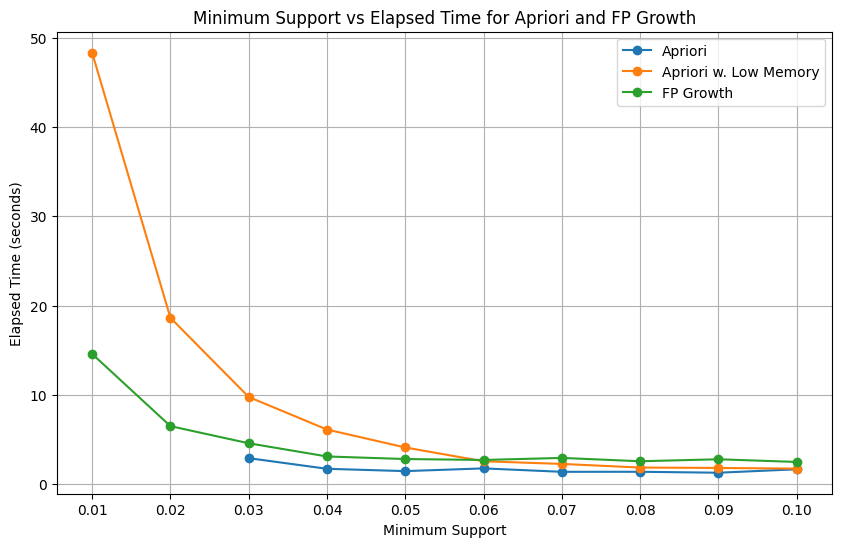

In [ ]:
# Extract elapsed time for plotting
apriori_times = [value[1] for _, value in apriori_results.items()]
apriori_wlm_times = [value[1] for _, value in apriori_wlm_results.items()]
fpgrowth_times = [value[1] for _, value in fpgrowth_results.items()]

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(apriori_results.keys(), apriori_times, label='Apriori', marker='o')
plt.plot(apriori_wlm_results.keys(), apriori_wlm_times, label='Apriori w. Low Memory', marker='o')
plt.plot(fpgrowth_results.keys(), fpgrowth_times, label='FP Growth', marker='o')
plt.xticks(min_support_values)
plt.xlabel('Minimum Support')
plt.ylabel('Elapsed Time (seconds)')
plt.title('Minimum Support vs Elapsed Time for Apriori and FP Growth')
plt.legend()
plt.grid(True)
plt.show()

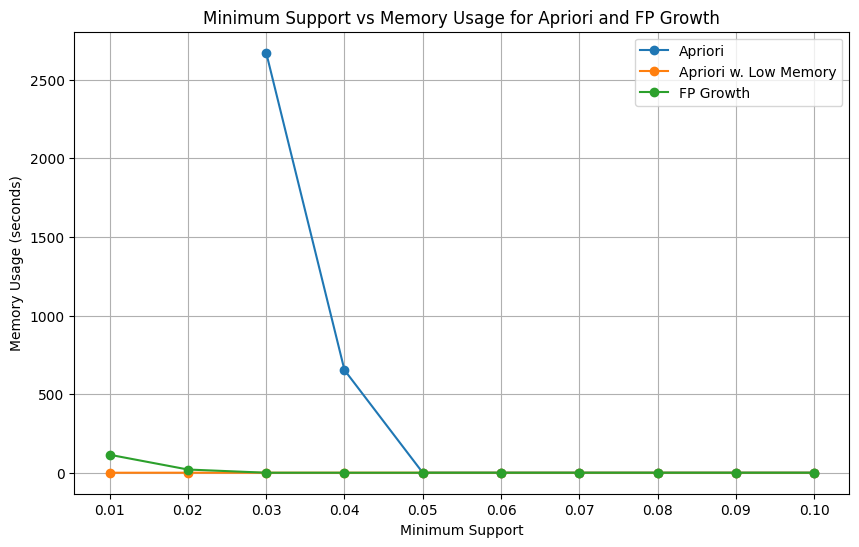

In [ ]:
# Extract memory usage for plotting
apriori_memories = [value[2] for _, value in apriori_results.items()]
apriori_wlm_memories = [value[2] for _, value in apriori_wlm_results.items()]
fpgrowth_memories = [value[2] for _, value in fpgrowth_results.items()]

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(apriori_results.keys(), apriori_memories, label='Apriori', marker='o')
plt.plot(apriori_wlm_results.keys(), apriori_wlm_memories, label='Apriori w. Low Memory', marker='o')
plt.plot(fpgrowth_results.keys(), fpgrowth_memories, label='FP Growth', marker='o')
plt.xticks(min_support_values)
plt.xlabel('Minimum Support')
plt.ylabel('Memory Usage (seconds)')
plt.title('Minimum Support vs Memory Usage for Apriori and FP Growth')
plt.legend()
plt.grid(True)
plt.show()

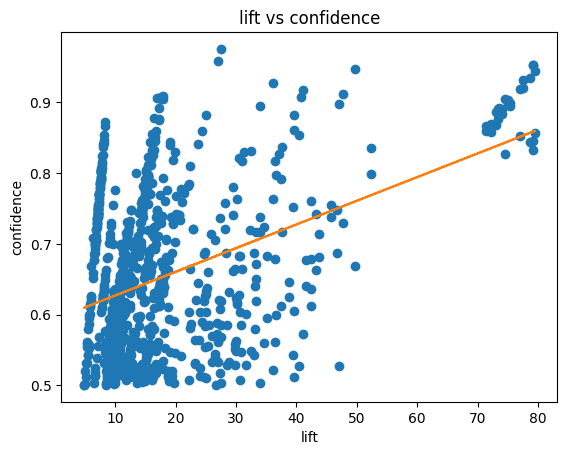

In [ ]:
plot_metrics_relationship(rulesF, "lift", "confidence")

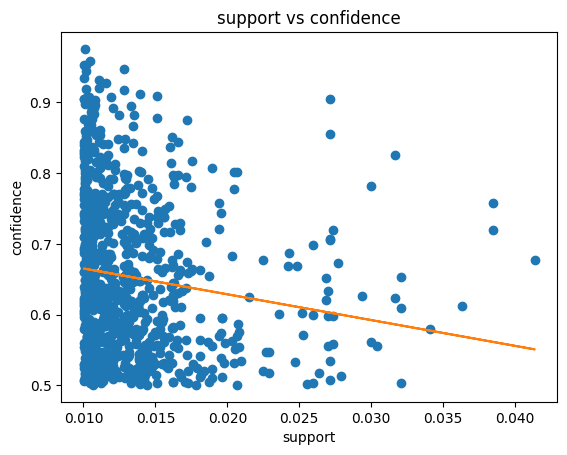

In [ ]:
plot_metrics_relationship(rulesF, "support", "confidence")

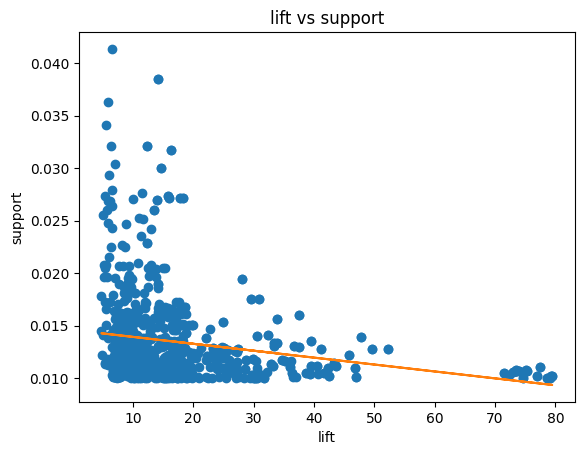

In [ ]:
plot_metrics_relationship(rulesF, "lift", "support")

##Visualization

In [ ]:
import re
def clean_str(s):
    cleaned = re.sub(r'[^a-zA-Z0-9 ,]','', str(s))
    return cleaned

In [ ]:
rules = rulesF.copy()
rules['antecedents'] = rules['antecedents'].map(lambda x: clean_str(str(x)[10:]))
rules['consequents'] = rules['consequents'].map(lambda x: clean_str(str(x)[10:]))
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift
0,POPPYS PLAYHOUSE KITCHEN,POPPYS PLAYHOUSE BEDROOM,0.021759,0.021107,0.015592,0.716590,33.950360
1,POPPYS PLAYHOUSE BEDROOM,POPPYS PLAYHOUSE KITCHEN,0.021107,0.021759,0.015592,0.738717,33.950360
2,"JAM MAKING SET WITH JARS, SET OF 3 CAKE TINS P...",JAM MAKING SET PRINTED,0.019051,0.058257,0.010328,0.542105,9.305363
3,"JAM MAKING SET PRINTED, SET OF 3 CAKE TINS PAN...",JAM MAKING SET WITH JARS,0.017397,0.056653,0.010328,0.593660,10.478886
4,ALARM CLOCK BAKELIKE GREEN,ALARM CLOCK BAKELIKE RED,0.049133,0.052642,0.032087,0.653061,12.405675
...,...,...,...,...,...,...,...
890,SET OF 12 MINI LOAF BAKING CASES,SET OF 6 SNACK LOAF BAKING CASES,0.022260,0.017748,0.011782,0.529279,29.822047
891,SET OF 6 TEA TIME BAKING CASES,SET OF 6 SNACK LOAF BAKING CASES,0.018951,0.017748,0.010378,0.547619,30.855394
892,SET OF 6 SNACK LOAF BAKING CASES,SET OF 6 TEA TIME BAKING CASES,0.017748,0.018951,0.010378,0.584746,30.855394
893,JUMBO BAG VINTAGE DOILY,JUMBO BAG RED RETROSPOT,0.035646,0.104733,0.017848,0.500703,4.780769


In [ ]:
from tqdm import tqdm
new_data = []

# Iterate over each transaction in the basket
for invoice_no, transaction in tqdm(basket.iterrows()):
  # Get the items in the transaction
  items = transaction[transaction == 1].index.tolist()

  # Find frequent itemsets that are subsets of the transaction
  relevant_itemsets = frequent_itemsets_fp[frequent_itemsets_fp['itemsets'].apply(lambda x: len(x)>1 and x.issubset(items))]

  # Get InvoiceDate, CustomerID, Country, and Sum Sales
  invoice_data = df[df['InvoiceNo'] == invoice_no]
  invoice_date = invoice_data['InvoiceDate'].iloc[0] if not invoice_data.empty else None
  customer_id = invoice_data['CustomerID'].iloc[0] if not invoice_data.empty else None
  country = invoice_data['Country'].iloc[0] if not invoice_data.empty else None

  # Append data for each relevant itemset to the new_data list
  for _, itemset in relevant_itemsets.iterrows():
    sum_sales = invoice_data[invoice_data['Description'].isin(list(itemset.itemsets))]['Sales'].sum() if not invoice_data.empty else None
    sum_unit = invoice_data[invoice_data['Description'].isin(list(itemset.itemsets))]['UnitPrice'].sum() if not invoice_data.empty else None
    new_data.append([invoice_no, clean_str(str(itemset['itemsets'])[10:]), invoice_date, customer_id, country, round(sum_sales,2)])

# Create the new DataFrame
itemset_df = pd.DataFrame(new_data, columns=['InvoiceNo', 'Itemsets', 'InvoiceDate', 'CustomerID', 'Country', 'TotalBill'])

19946it [27:09, 12.24it/s]


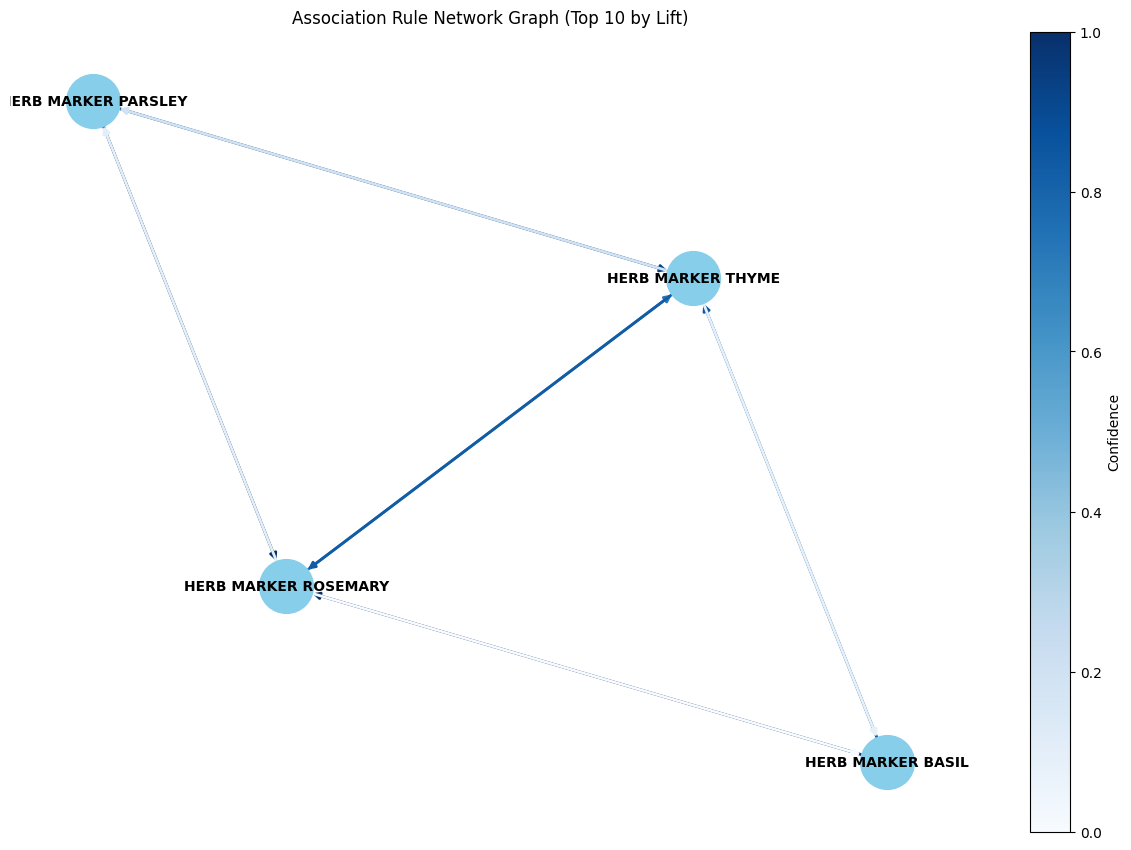

In [ ]:
import networkx as nx

top_rules = rulesF.sort_values('lift', ascending=False).head(10)

G = nx.DiGraph()

# Add nodes and edges for top rules
items = set()
for index, row in top_rules.iterrows():
    for item in row['antecedents']:
        items.add(item)
    for item in row['consequents']:
        items.add(item)
G.add_nodes_from(items)

for index, row in top_rules.iterrows():
    for antecedent in row['antecedents']:
        for consequent in row['consequents']:
            G.add_edge(antecedent, consequent, weight=row['confidence'])

# Set node positions using spring layout
pos = nx.spring_layout(G)

# Draw the graph
plt.figure(figsize=(12, 8))
nx.draw(G, pos, with_labels=True, node_size=1500, node_color="skyblue", font_size=10, font_weight="bold",
        edge_color=[d['weight'] for (u, v, d) in G.edges(data=True)], width=2, edge_cmap=plt.cm.Blues)

# Add a colorbar for edge weights
plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.Blues), label='Confidence')
plt.title("Association Rule Network Graph (Top 10 by Lift)")
plt.show()


In [ ]:
from sklearn.cluster import DBSCAN
def custom_dbscan(X, eps, min_samples, max_samples):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='precomputed')
    labels = dbscan.fit_predict(X)
    unique_labels = set(labels)
    unique_labels.discard(-1)  # loại bỏ nhãn nhiễu
    large_clusters = {label for label in unique_labels if np.sum(labels == label) > max_samples}
    while len(large_clusters):
        eps = eps/1.2
        next_label = max(labels) + 1
        flag = len(large_clusters)
        for label in large_clusters:
            cluster_indices = np.where(labels == label)[0]
            cluster_points = X.iloc[cluster_indices, cluster_indices]
            # Bước 3: Áp dụng DBSCAN cho các cụm lớn
            sub_dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='precomputed')
            sub_labels = sub_dbscan.fit_predict(cluster_points)
            if all(element == -1 for element in sub_labels):
                flag-=1
                continue
            # Cập nhật nhãn
            for sub_label in set(sub_labels):
                if sub_label != -1:  # không thay đổi nhiễu
                    labels[cluster_indices[sub_labels == sub_label]] = next_label + sub_label
        if not flag: return labels
        unique_labels = set(labels)
        unique_labels.discard(-1)  # loại bỏ nhãn nhiễu
        large_clusters = {label for label in unique_labels if np.sum(labels == label) > max_samples}
    return labels

In [ ]:
top_rules = rules.sort_values('lift', ascending=False)

# Chuyển đổi các cột antecedents và consequents từ chuỗi thành các tập hợp
top_rules['antecedents'] = top_rules['antecedents'].apply(lambda x: set(x.strip("{}").replace("'", "").split(", ")))
top_rules['consequents'] = top_rules['consequents'].apply(lambda x: set(x.strip("{}").replace("'", "").split(", ")))

# Tạo list các item từ các cột antecedents và consequents
items = list(set.union(*top_rules['antecedents']) | set.union(*top_rules['consequents']))

# Tạo ma trận lift giữa các itemset
lift_matrix = pd.DataFrame(1, index=items, columns=items)

for item in items:
    lift_matrix.loc[item, item] = 0

for index, row in top_rules.iterrows():
    for antecedent in row['antecedents']:
        for consequent in row['consequents']:
            lift_matrix.loc[antecedent, consequent] = min(1/row['lift'], lift_matrix.loc[antecedent, consequent])
            lift_matrix.loc[consequent, antecedent] = min(1/row['lift'], lift_matrix.loc[consequent, antecedent])

cluster = pd.DataFrame(index=lift_matrix.index)
cluster['Cluster'] = custom_dbscan(lift_matrix, eps=0.5, min_samples=2, max_samples=10)

clusters = cluster.groupby('Cluster').apply(lambda x: x.index.tolist())
for cluster_id, items in clusters.items():
    print(f'Cụm {cluster_id+1}: {items}')

Cụm 1: ['HERB MARKER ROSEMARY', 'HERB MARKER BASIL', 'HERB MARKER MINT', 'HERB MARKER THYME', 'HERB MARKER PARSLEY']
Cụm 2: ['PLASTERS IN TIN WOODLAND ANIMALS', 'PLASTERS IN TIN SPACEBOY']
Cụm 3: ['SET OF 60 VINTAGE LEAF CAKE CASES ', 'SET OF 60 I LOVE LONDON CAKE CASES ', 'SET OF 60 PANTRY DESIGN CAKE CASES ']
Cụm 5: ['PINK BLUE FELT CRAFT TRINKET BOX', 'PINK CREAM FELT CRAFT TRINKET BOX ']
Cụm 6: ['HAND WARMER SCOTTY DOG DESIGN', 'HAND WARMER BIRD DESIGN', 'HAND WARMER RED LOVE HEART', 'HAND WARMER RED RETROSPOT', 'HAND WARMER OWL DESIGN']
Cụm 7: ['SPACEBOY LUNCH BOX ', 'DOLLY GIRL LUNCH BOX']
Cụm 8: ['BAKING SET 9 PIECE RETROSPOT ', 'BAKING SET SPACEBOY DESIGN']
Cụm 9: ['RED STRIPE CERAMIC DRAWER KNOB', 'RED SPOT CERAMIC DRAWER KNOB', 'WHITE SPOT RED CERAMIC DRAWER KNOB', 'WHITE SPOT BLUE CERAMIC DRAWER KNOB', 'BLUE STRIPE CERAMIC DRAWER KNOB', 'BLUE SPOT CERAMIC DRAWER KNOB']
Cụm 10: ['JAM JAR WITH PINK LID', 'JAM JAR WITH GREEN LID']
Cụm 11: ['CHOCOLATE HOT WATER BOTTLE', 'HOT WAT

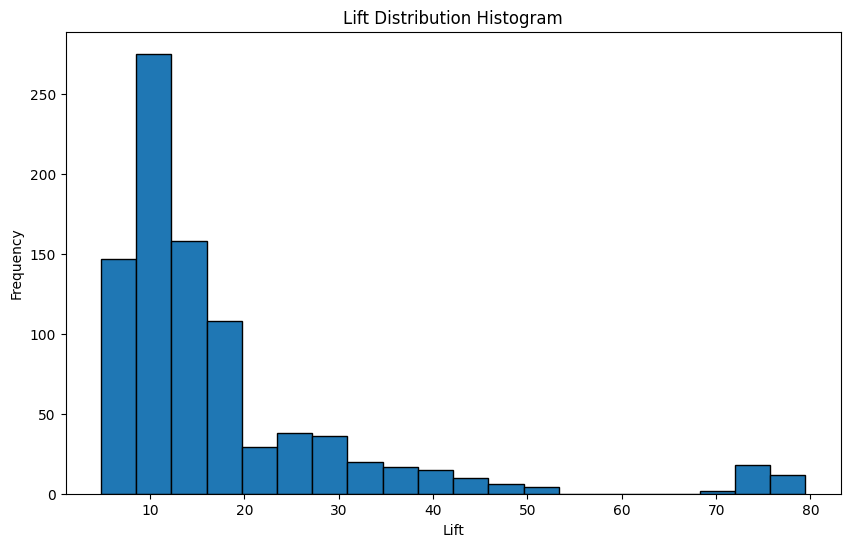

In [ ]:
# Plot lift distribution histogram
plt.figure(figsize=(10, 6))
plt.hist(rulesF['lift'], bins=20, edgecolor='black')
plt.xlabel('Lift')
plt.ylabel('Frequency')
plt.title('Lift Distribution Histogram')
plt.show()

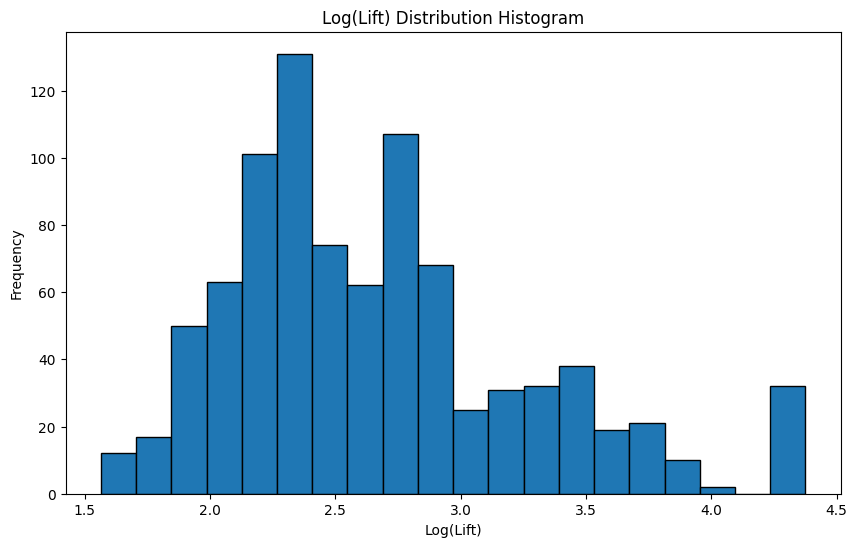

In [ ]:
# Plot log(lift) distribution histogram
plt.figure(figsize=(10, 6))
plt.hist(np.log(rulesF['lift']), bins=20, edgecolor='black')
plt.xlabel('Log(Lift)')
plt.ylabel('Frequency')
plt.title('Log(Lift) Distribution Histogram')
plt.show()

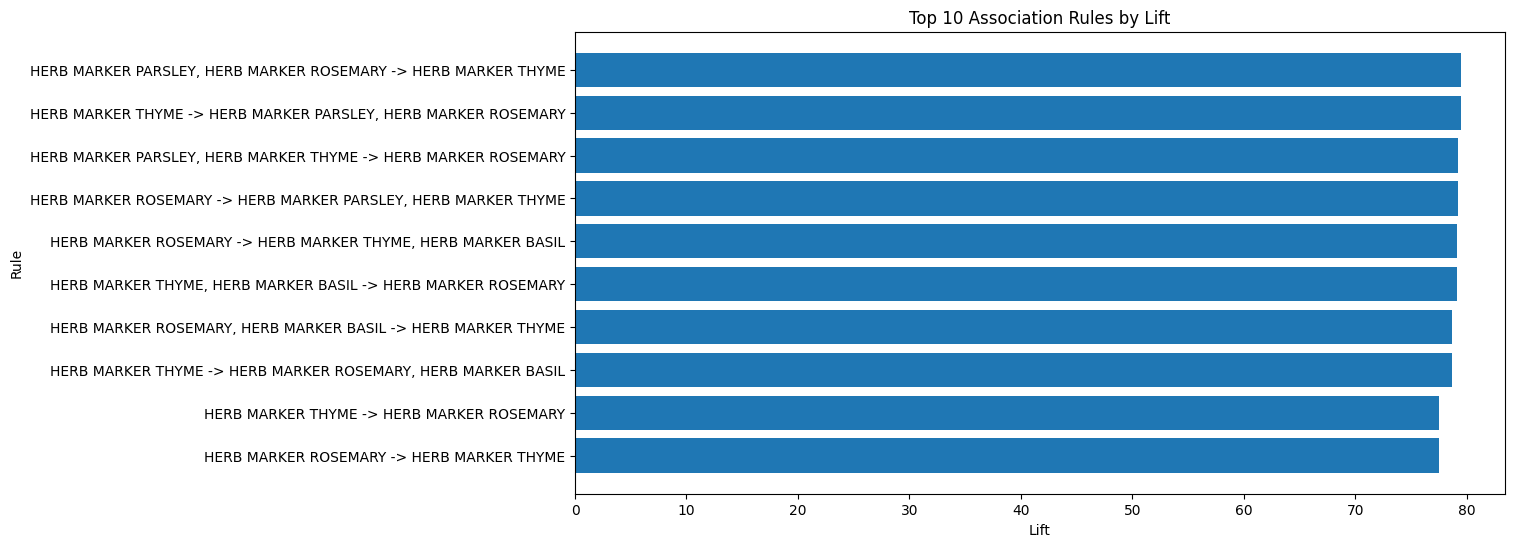

In [ ]:
top_rules_lift = rules.sort_values('lift', ascending=False).head(10)

# Plot top 10 rules by lift
plt.figure(figsize=(12, 6))
plt.barh(top_rules_lift['antecedents'] + ' -> ' + top_rules_lift['consequents'], top_rules_lift['lift'])
plt.xlabel('Lift')
plt.ylabel('Rule')
plt.title('Top 10 Association Rules by Lift')
plt.gca().invert_yaxis()  # Invert y-axis to show highest lift at the top
plt.show()

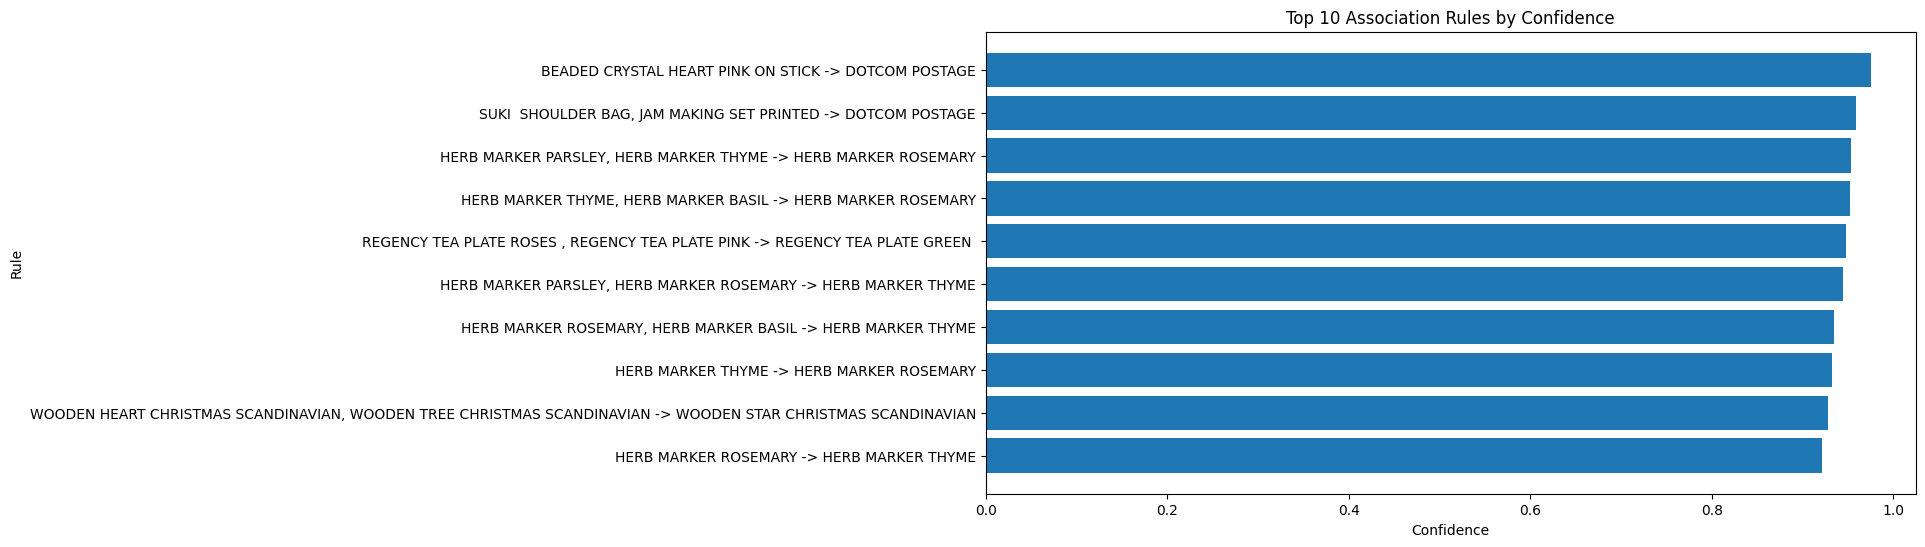

In [ ]:
top_rules_confidence = rules.sort_values('confidence', ascending=False).head(10)

# Plot top 10 rules by confidence
plt.figure(figsize=(12, 6))
plt.barh(top_rules_confidence['antecedents'] + ' -> ' + top_rules_confidence['consequents'], top_rules_confidence['confidence'])
plt.xlabel('Confidence')
plt.ylabel('Rule')
plt.title('Top 10 Association Rules by Confidence')
plt.gca().invert_yaxis()  # Invert y-axis to show highest confidence at the top
plt.show()

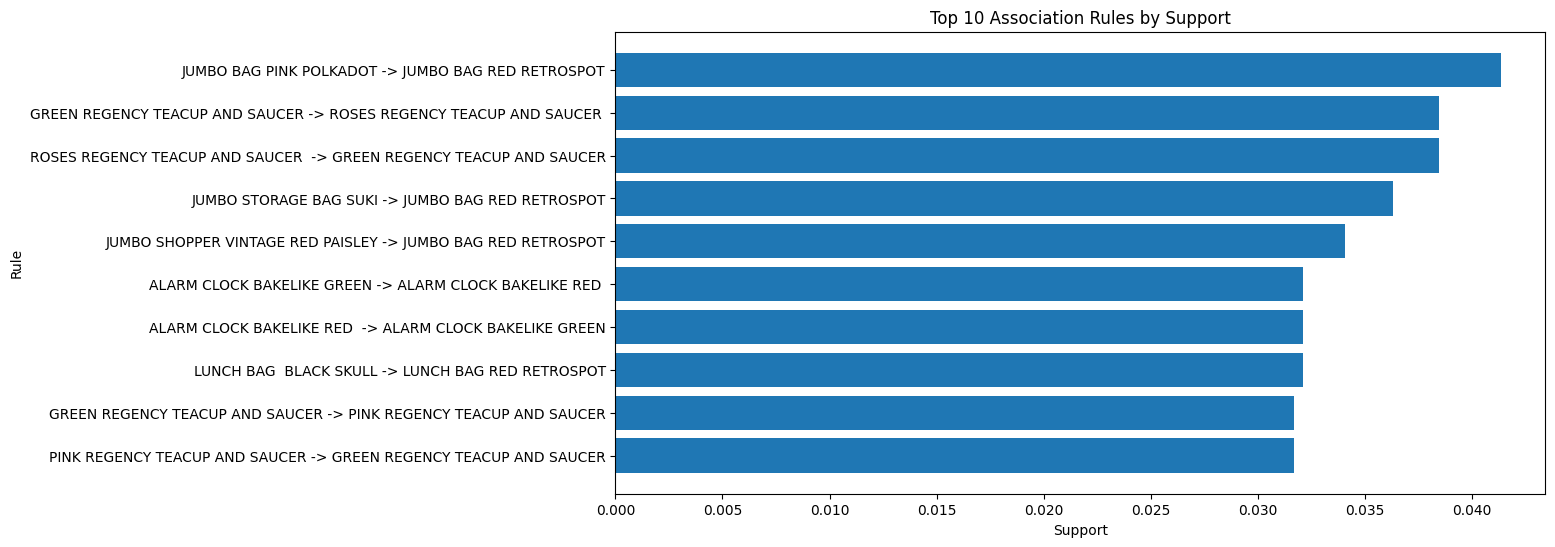

In [ ]:
top_rules_support = rules.sort_values('support', ascending=False).head(10)

# Plot top 10 rules by support
plt.figure(figsize=(12, 6))
plt.barh(top_rules_support['antecedents'] + ' -> ' + top_rules_support['consequents'], top_rules_support['support'])
plt.xlabel('Support')
plt.ylabel('Rule')
plt.title('Top 10 Association Rules by Support')
plt.gca().invert_yaxis()  # Invert y-axis to show highest support at the top
plt.show()

In [ ]:
# Calculate frequency of antecedent and consequent
antecedent_freq = defaultdict(int)
consequent_freq = defaultdict(int)

for _, row in rulesF.iterrows():
    for item in row['antecedents']:
        antecedent_freq[item] += 1
    for item in row['consequents']:
        consequent_freq[item] += 1

n_top = 20

# Sort and get top 10 frequent items for antecedents and consequents
top_antecedents = sorted(antecedent_freq.items(), key=lambda x: x[1], reverse=True)[:n_top]
top_consequents = sorted(consequent_freq.items(), key=lambda x: x[1], reverse=True)[:n_top]
bottom_consequents = sorted(consequent_freq.items(), key=lambda x: x[1], reverse=True)[-n_top:]

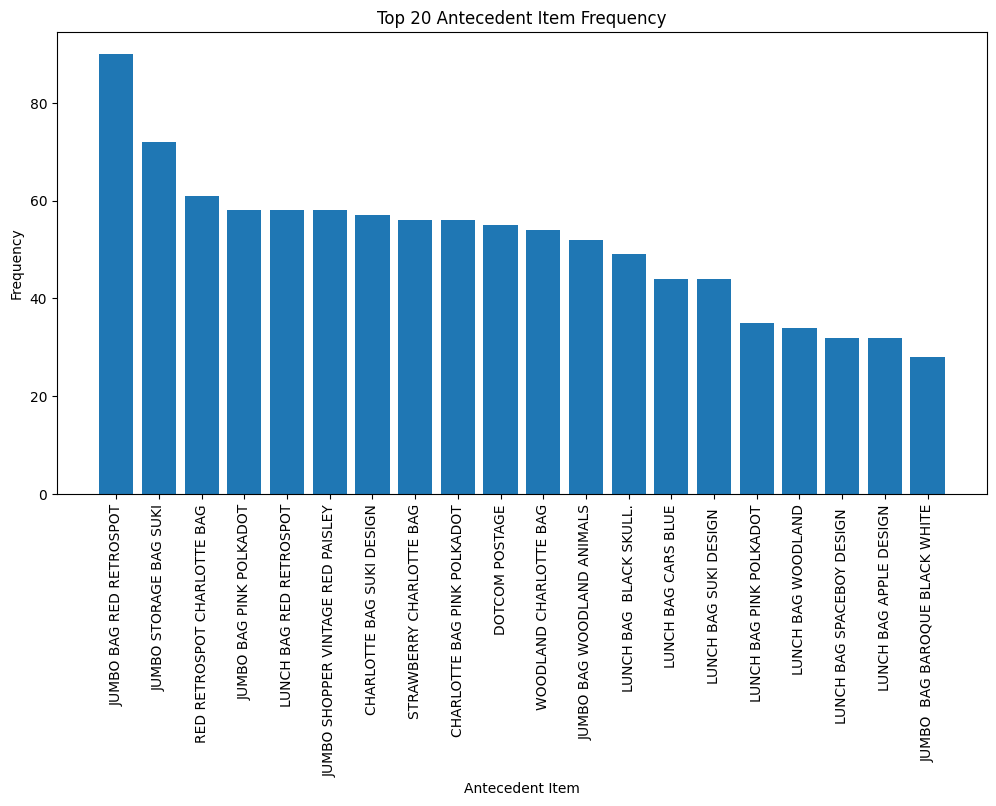

In [ ]:
# Plot antecedent item frequency
plt.figure(figsize=(12, 6))
plt.bar([item for item, _ in top_antecedents], [freq for _, freq in top_antecedents])
plt.xlabel('Antecedent Item')
plt.ylabel('Frequency')
plt.title(f'Top {n_top} Antecedent Item Frequency')
plt.xticks(rotation=90)
plt.show()

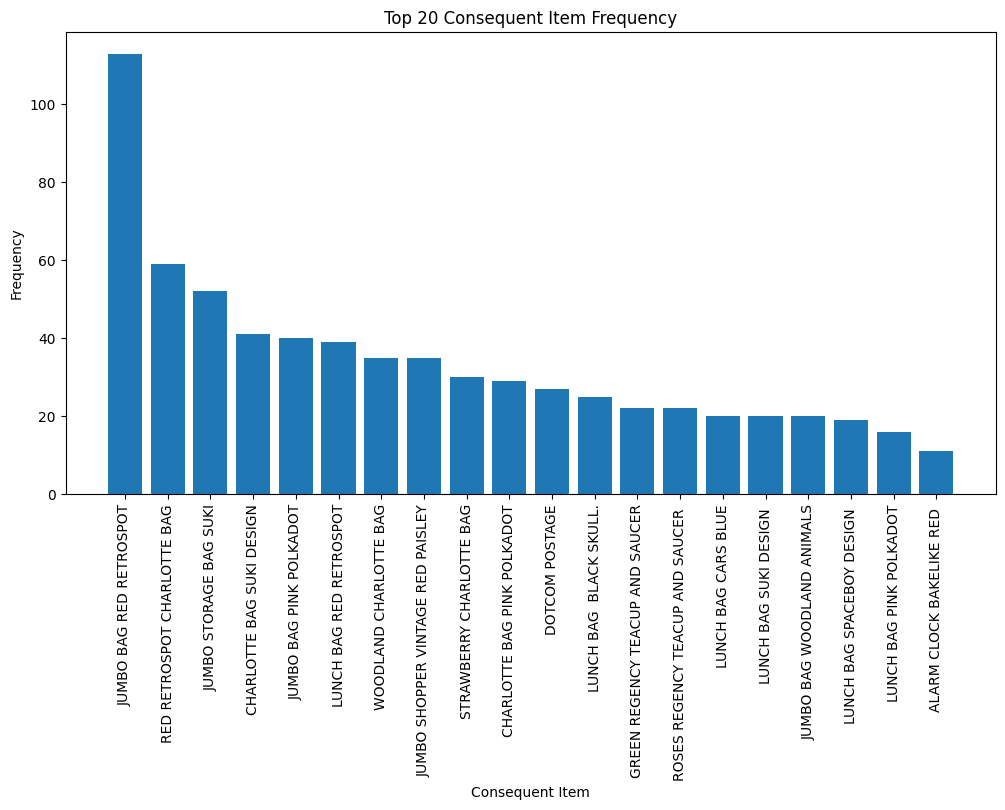

In [ ]:
# Plot consequent item frequency
plt.figure(figsize=(12, 6))
plt.bar([item for item, _ in top_consequents], [freq for _, freq in top_consequents])
plt.xlabel('Consequent Item')
plt.ylabel('Frequency')
plt.title(f'Top {n_top} Consequent Item Frequency')
plt.xticks(rotation=90)
plt.show()

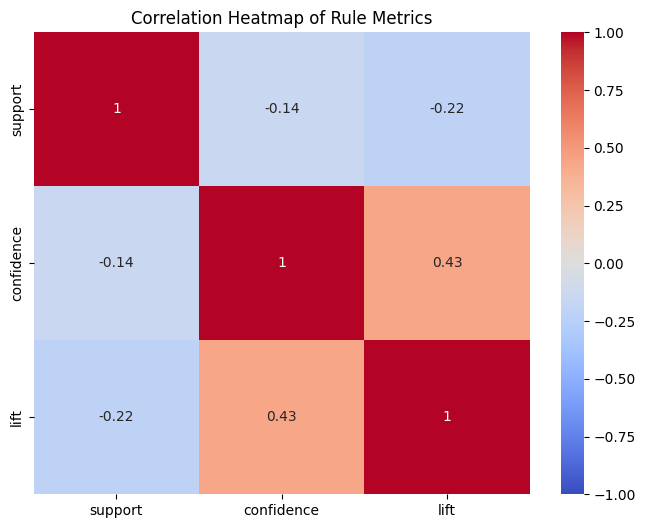

In [ ]:
# Select relevant metrics for the heatmap
metrics = ['support', 'confidence', 'lift']

# Calculate correlation matrix
corr_matrix = rulesF[metrics].corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Rule Metrics')
plt.show()

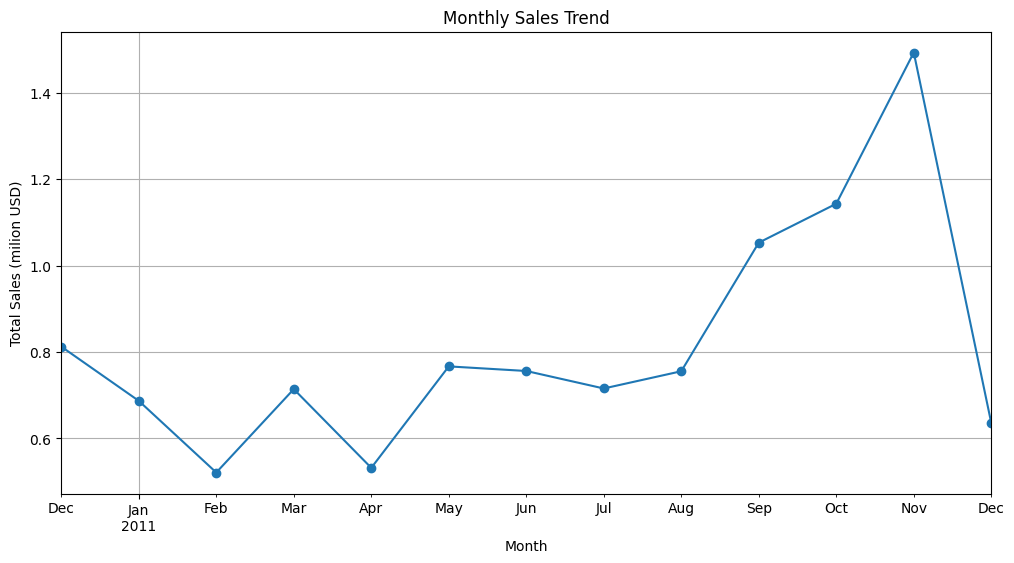

In [ ]:
# Group data by month and calculate total sales
monthly_sales = df.groupby(pd.to_datetime(df['InvoiceDate'], format='%d/%m/%Y').dt.to_period('M'))['Sales'].sum()/1e6

# Plot monthly sales trend
plt.figure(figsize=(12, 6))
monthly_sales.plot(kind='line', marker='o')
plt.xlabel('Month')
plt.ylabel('Total Sales (milion USD)')
plt.title('Monthly Sales Trend')
plt.grid(True)
plt.show()

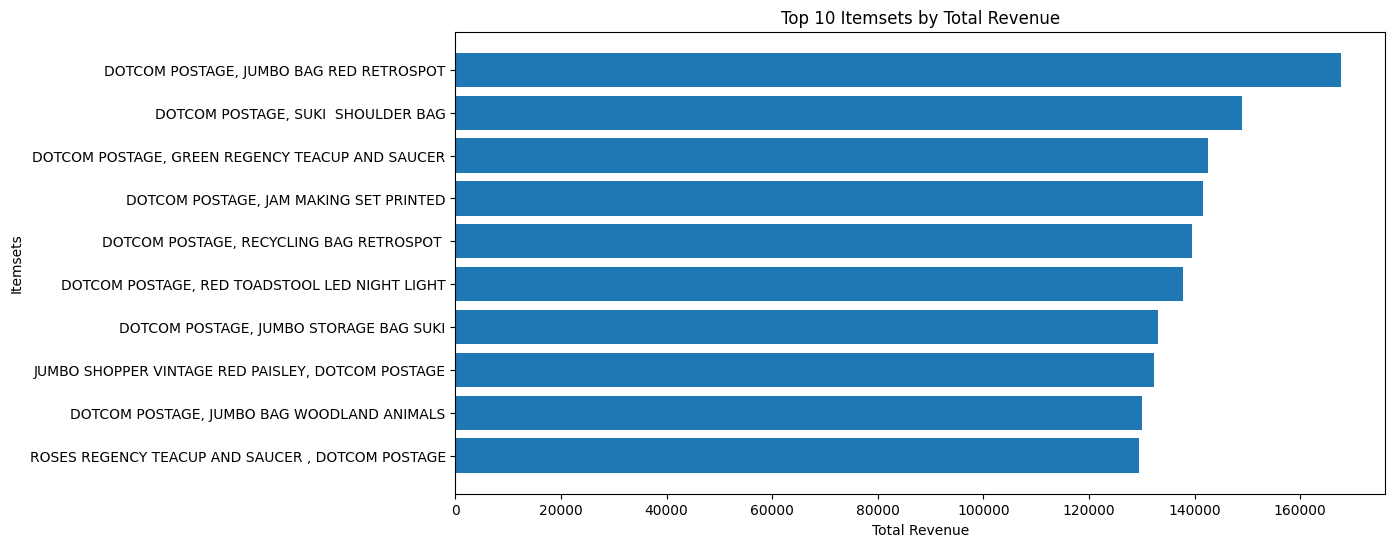

In [ ]:
# Group itemset_df by 'Itemsets' and calculate total revenue
itemset_revenue = itemset_df.groupby('Itemsets')['TotalBill'].sum().sort_values(ascending=False)

# Select top 10 itemsets
top_10_itemsets = itemset_revenue.head(10)

# Plot barh chart
plt.figure(figsize=(12, 6))
plt.barh(top_10_itemsets.index, top_10_itemsets.values)
plt.xlabel('Total Revenue')
plt.ylabel('Itemsets')
plt.title('Top 10 Itemsets by Total Revenue')
plt.gca().invert_yaxis()  # Invert y-axis to show highest revenue at the top
plt.show()

In [ ]:
def wrap_text(s, max_length):
    words = s.split()
    current_line = []
    current_length = 0
    result = []
    for word in words:
        if current_length + len(word) + len(current_line) > max_length:
            result.append(" ".join(current_line))
            current_line = [word]
            current_length = len(word)
        else:
            current_line.append(word)
            current_length += len(word)
    if current_line:
        result.append(" ".join(current_line))
    return "\n".join(result)

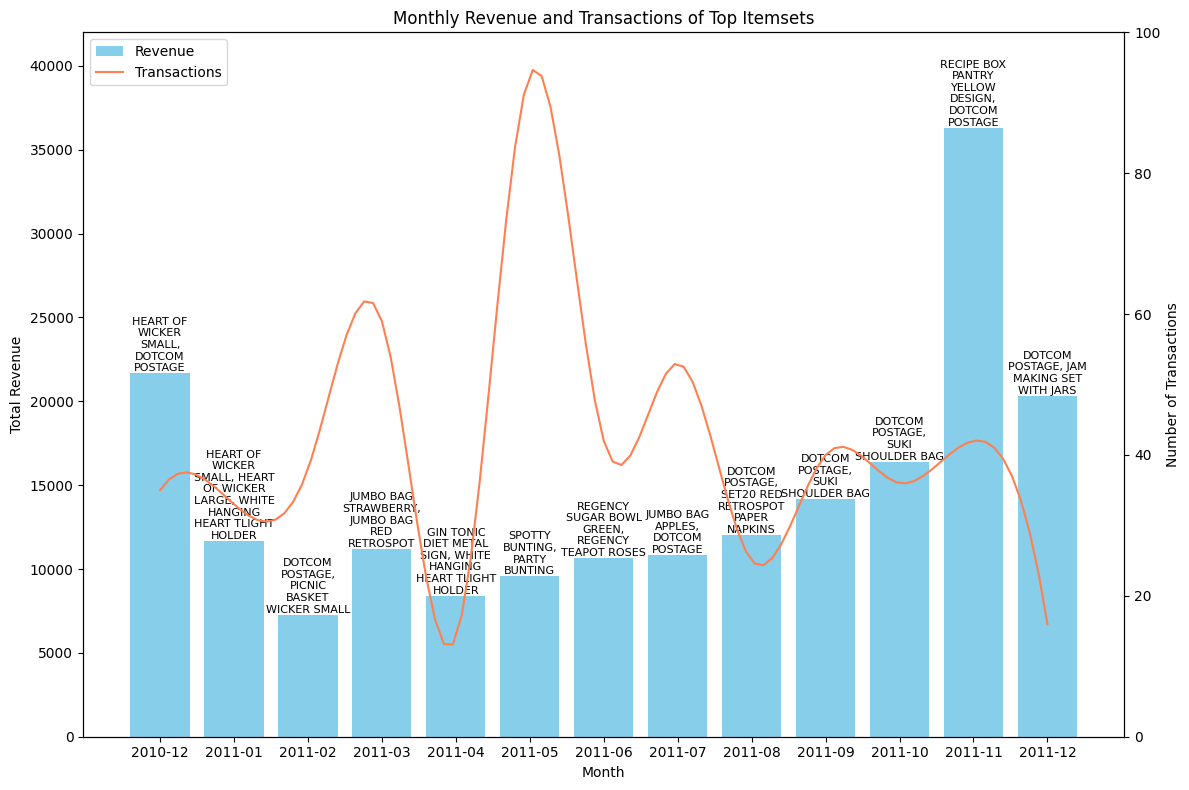

In [ ]:
# Group itemset_df by month and itemset, calculate total revenue and count transactions
monthly_itemset_data = itemset_df.groupby([pd.to_datetime(itemset_df['InvoiceDate'], format='%d/%m/%Y').dt.to_period('M'), 'Itemsets']).agg({'TotalBill': 'sum', 'InvoiceNo': 'nunique'})
monthly_itemset_data.rename(columns={'TotalBill': 'TotalRevenue', 'InvoiceNo': 'NumberOfTransactions'}, inplace=True)

# Get top itemset for each month
top_itemsets_by_month = monthly_itemset_data.loc[monthly_itemset_data.groupby(level=0)['TotalRevenue'].idxmax(), ['TotalRevenue', 'NumberOfTransactions']]
top_itemsets_by_month = top_itemsets_by_month.reset_index().set_index('InvoiceDate')
# Create figure and axes
fig, ax1 = plt.subplots(figsize=(12, 8))
ax2 = ax1.twinx()
ax1.set_ylim(0, 42000)
# Plot bar chart for revenue
ax1.bar(top_itemsets_by_month.index.astype(str), top_itemsets_by_month['TotalRevenue'], color='skyblue', label='Revenue')
ax1.set_xlabel('Month')
ax1.set_ylabel('Total Revenue')
xnew, ynew = smooth(range(len(top_itemsets_by_month.index)), top_itemsets_by_month['NumberOfTransactions'])
# Plot line chart for number of transactions
ax2.plot(xnew, ynew, color='coral', label='Transactions')
ax2.set_ylabel('Number of Transactions')
ax2.set_ylim(0, 100)

for i in range(len(top_itemsets_by_month)):
    ax1.text(str(top_itemsets_by_month.index[i]), top_itemsets_by_month['TotalRevenue'][i], wrap_text(str(top_itemsets_by_month['Itemsets'][i]), 12), ha='center', va='bottom', fontsize=8)

# Set title and legend
plt.title('Monthly Revenue and Transactions of Top Itemsets')
fig.legend(loc="upper left", bbox_to_anchor=(0,1), bbox_transform=ax1.transAxes)
plt.tight_layout()
plt.show()

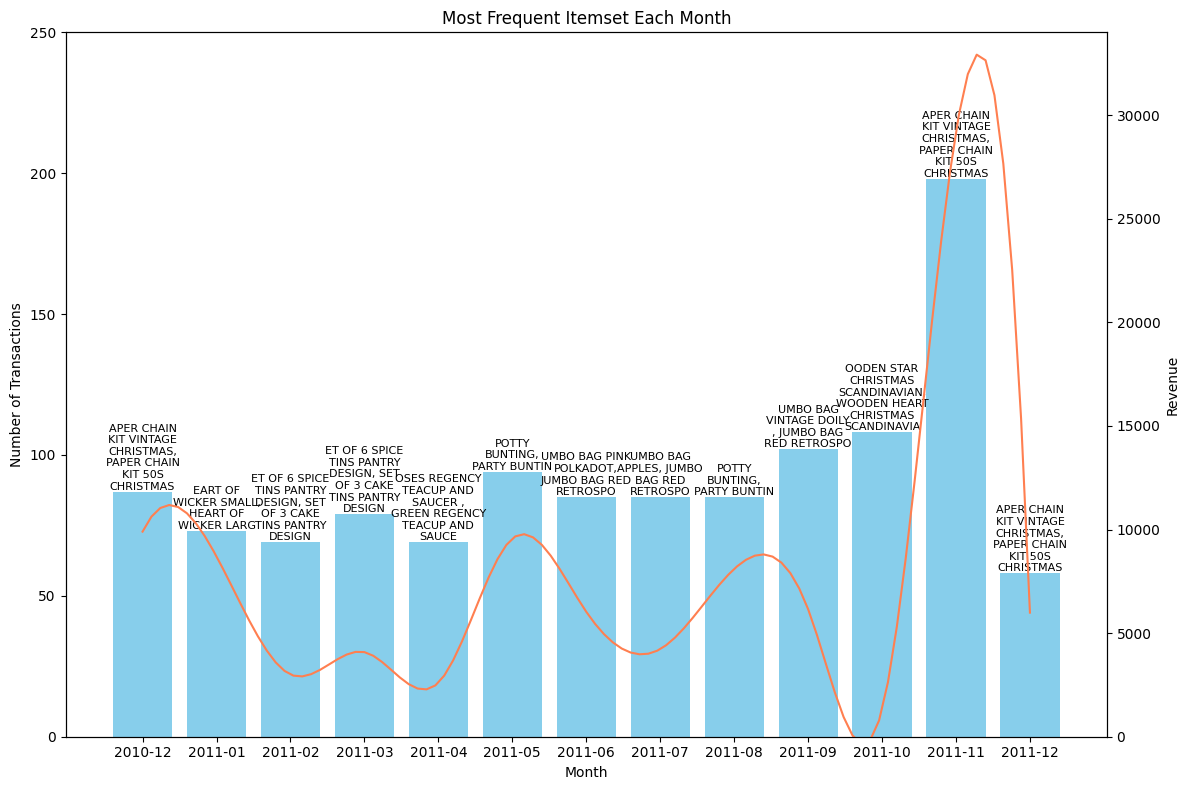

In [ ]:
# Group data by month and itemset, count transactions
monthly_itemset_counts = itemset_df.groupby([pd.Grouper(key='InvoiceDate', freq='M'), 'Itemsets']).agg({'TotalBill': 'sum', 'InvoiceNo': 'nunique'}).reset_index()

# Find the most frequent itemset for each month
most_frequent_itemsets = monthly_itemset_counts.loc[monthly_itemset_counts.groupby(pd.Grouper(key='InvoiceDate', freq='M'))['InvoiceNo'].idxmax()]

# Plot the column chart
fig, ax1 = plt.subplots(figsize=(12, 8))
bars = ax1.bar(most_frequent_itemsets['InvoiceDate'].dt.strftime('%Y-%m'), most_frequent_itemsets['InvoiceNo'], color='skyblue')
ax1.set_xlabel('Month')
ax1.set_ylabel('Number of Transactions')
plt.title('Most Frequent Itemset Each Month')
ax1.set_ylim(0,250)
# Add itemset names as text on each column
for bar, itemset in zip(bars, most_frequent_itemsets['Itemsets']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), wrap_text(itemset[1:-1], 13), ha='center', va='bottom', fontsize=8)
ax2 = ax1.twinx()
xnew, ynew = smooth(range(len(most_frequent_itemsets['InvoiceDate'].dt.strftime('%Y-%m'))), most_frequent_itemsets['TotalBill'])
ax2.plot(xnew, ynew, color='coral', label='Revenue')
ax2.set_ylabel('Revenue')
ax2.set_ylim(0, 34000)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


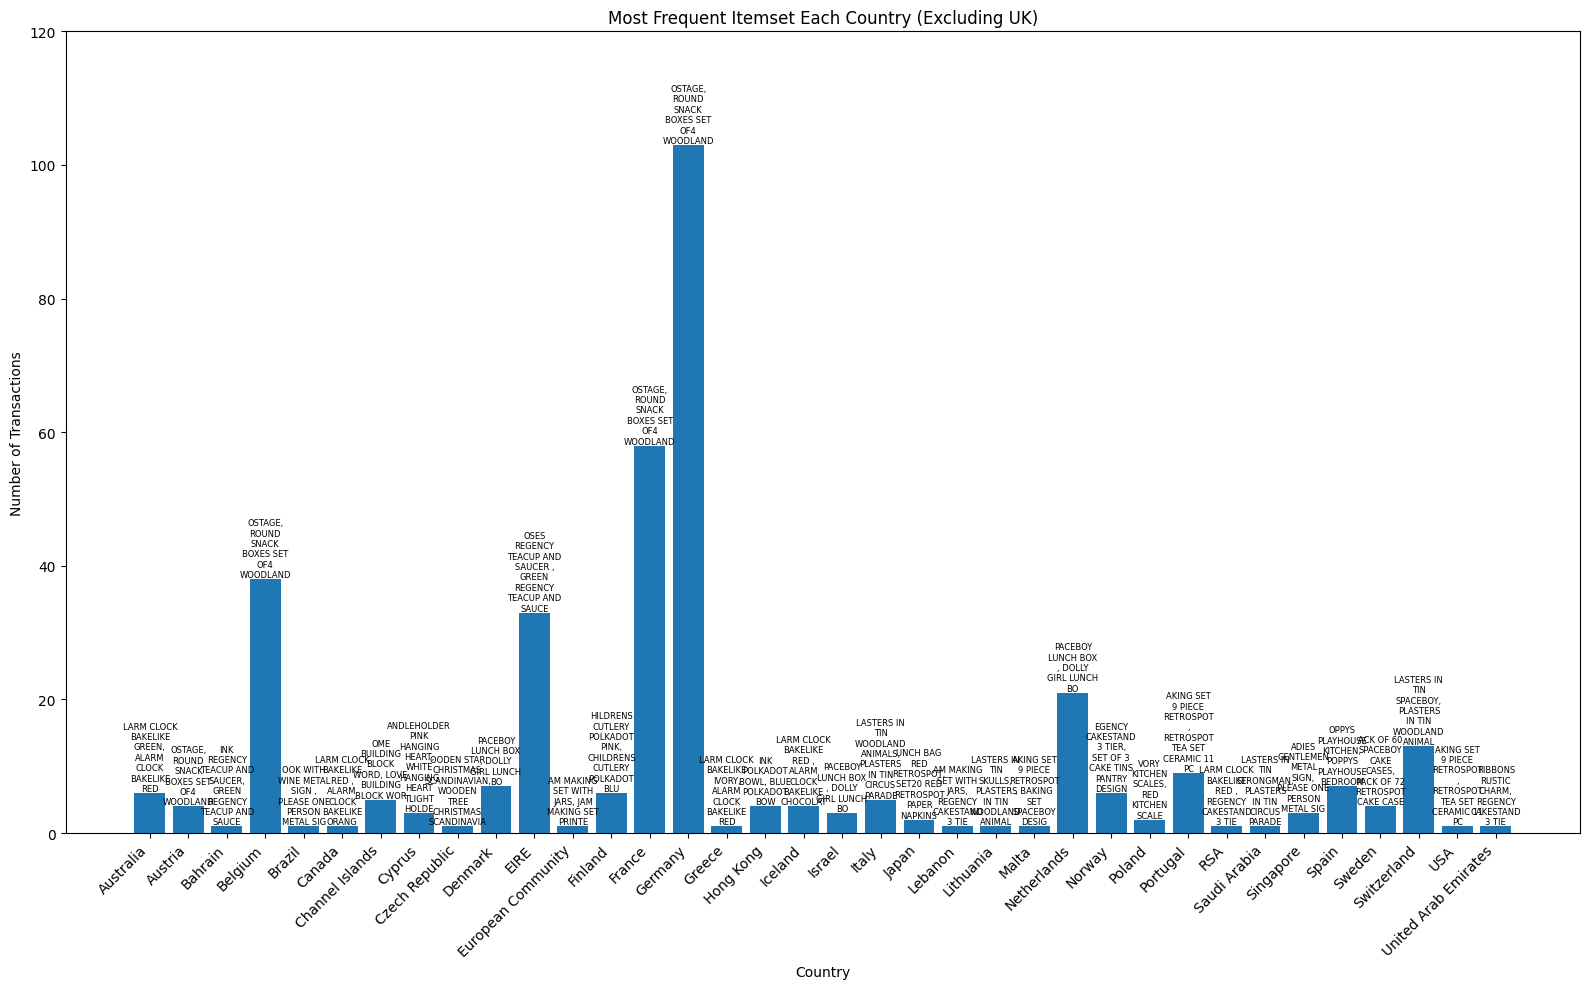

In [ ]:
country_itemset_counts = itemset_df[itemset_df['Country'] != 'United Kingdom'].groupby(['Country', 'Itemsets'])['InvoiceNo'].count().reset_index()

# Find the most frequent itemset for each country
most_frequent_itemsets = country_itemset_counts.loc[country_itemset_counts.groupby('Country')['InvoiceNo'].idxmax()]

# Plot the column chart
plt.figure(figsize=(16, 10))
bars = plt.bar(most_frequent_itemsets['Country'], most_frequent_itemsets['InvoiceNo'])
plt.xlabel('Country')
plt.ylabel('Number of Transactions')
plt.title('Most Frequent Itemset Each Country (Excluding UK)')
plt.ylim(0,120)
# Add itemset names as text on each column
for bar, itemset in zip(bars, most_frequent_itemsets['Itemsets']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), wrap_text(itemset[1:-1], 10), ha='center', va='bottom', fontsize=6)

plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

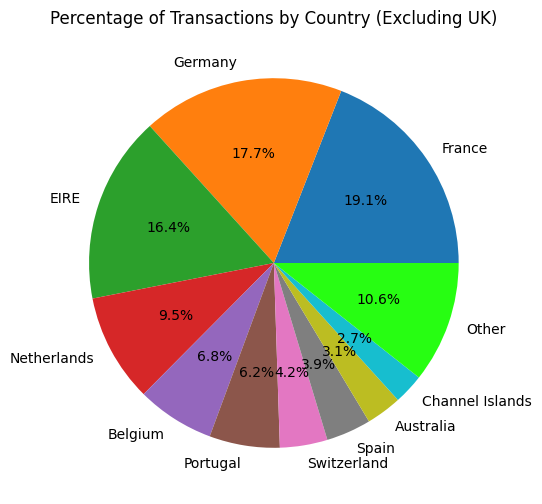

In [ ]:
country_transactions = itemset_df[itemset_df['Country'] != 'United Kingdom']['Country'].value_counts()

# Calculate percentage of transactions for each country
country_percentages = country_transactions / country_transactions.sum() * 100

# Group countries with less than 1% transactions into 'Other'
other_percentage = country_percentages[country_percentages < 2].sum()
top_countries = country_percentages[country_percentages >= 2]
top_countries['Other'] = other_percentage

# Plot pie chart
plt.figure(figsize=(10, 6))
plt.pie(top_countries, labels=top_countries.index, autopct='%1.1f%%', startangle=0, colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#27fe12'])
plt.title('Percentage of Transactions by Country (Excluding UK)')
plt.show()

In [ ]:
frequent_itemsets = fpgrowth(basket, use_colnames=True, min_support=0.005)
rules_02 = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.2)

In [ ]:
single_consequent = rules_02[rules_02['consequents'].map(lambda x: len(str(x).split(','))<2)]

# Lọc các rules
filtered_rules = single_consequent[(single_consequent['antecedent support'] >= 0.05) & (single_consequent['consequent support'] <= 0.025)]

# Sắp xếp theo confidence giảm dần
sorted_rules = filtered_rules.sort_values('consequent support', ascending=True)
SKU_rules = sorted_rules.head(10).reset_index()
SKU_rules

,index,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,56876,(GREEN REGENCY TEACUP AND SAUCER),(REGENCY TEA PLATE GREEN ),0.050787,0.019102,0.012183,0.239882,12.558208,0.011213,1.290455,0.969615
1,56877,(ROSES REGENCY TEACUP AND SAUCER ),(REGENCY TEA PLATE GREEN ),0.053394,0.019102,0.011431,0.214085,11.207689,0.010411,1.248097,0.962149
2,774,(RED RETROSPOT CHARLOTTE BAG),(CHARLOTTE BAG DOLLY GIRL DESIGN),0.051589,0.020806,0.012032,0.233236,11.209948,0.010959,1.277047,0.960337
3,56777,(ROSES REGENCY TEACUP AND SAUCER ),(REGENCY TEAPOT ROSES ),0.053394,0.020856,0.011882,0.222535,10.669921,0.010768,1.259406,0.957398
4,44346,(ALARM CLOCK BAKELIKE RED ),(ALARM CLOCK BAKELIKE CHOCOLATE),0.052642,0.021458,0.014640,0.278095,12.960018,0.013510,1.355500,0.974119
5,12910,(ALARM CLOCK BAKELIKE RED ),(ALARM CLOCK BAKELIKE ORANGE),0.052642,0.022310,0.015141,0.287619,12.891797,0.013966,1.372425,0.973688
6,53849,(RED RETROSPOT CHARLOTTE BAG),(CHARLOTTE BAG VINTAGE ALPHABET ),0.051589,0.022310,0.012584,0.243926,10.933373,0.011433,1.293114,0.957957
7,56659,(ROSES REGENCY TEACUP AND SAUCER ),(REGENCY TEA PLATE ROSES ),0.053394,0.022310,0.013787,0.258216,11.573878,0.012596,1.318025,0.965131
8,56662,(GREEN REGENCY TEACUP AND SAUCER),(REGENCY TEA PLATE ROSES ),0.050787,0.022310,0.011230,0.221125,9.911386,0.010097,1.255259,0.947212


In [ ]:
# SKU_rules.to_csv("SKU.csv", index=False)

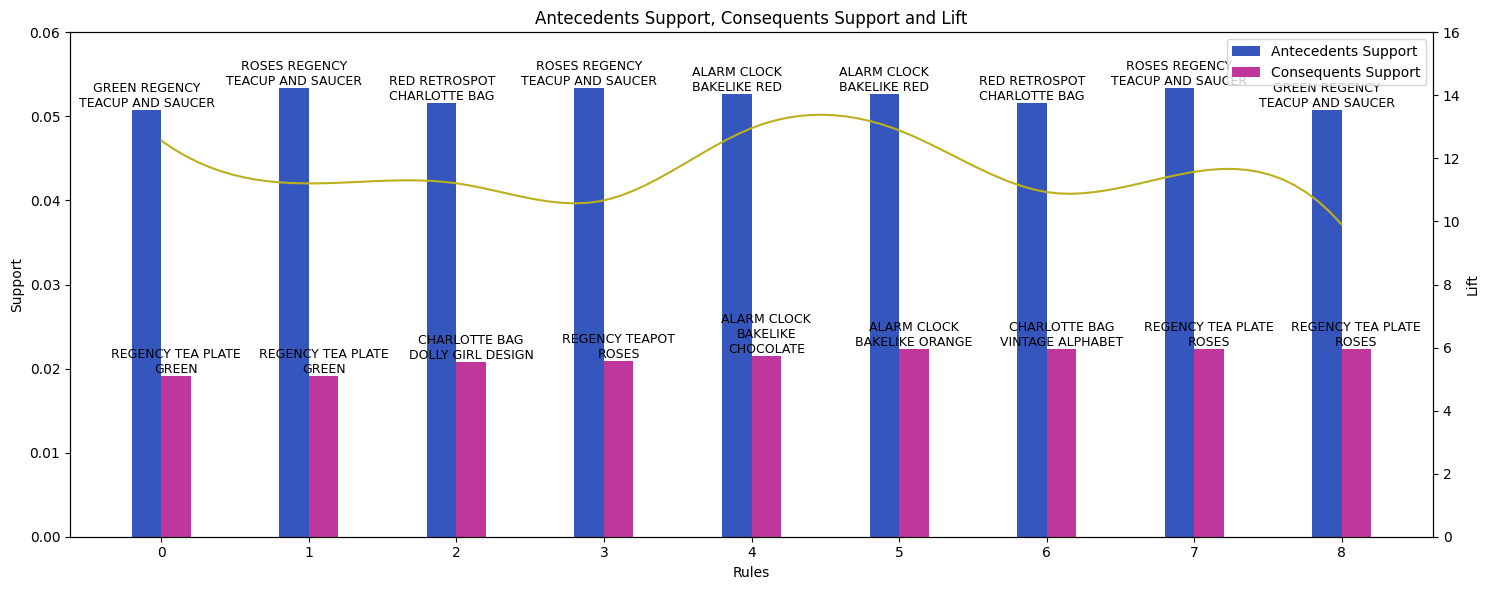

In [ ]:
from scipy.interpolate import interp1d

f_cubic = interp1d(SKU_rules.index, SKU_rules['lift'], kind='cubic')
xnew = np.linspace(0, len(SKU_rules)-1, num=101, endpoint=True)

fig, ax = plt.subplots(figsize=(15, 6))

ax.bar(SKU_rules.index-0.1, SKU_rules['antecedent support'], width=0.2, label='Antecedents Support', color='#3557bd')
ax.bar(SKU_rules.index+0.1, SKU_rules['consequent support'], width=0.2, label='Consequents Support', color='#bf379d')

for i in range(len(SKU_rules)):
    ax.text(SKU_rules.index[i]-0.1, SKU_rules['antecedent support'][i], wrap_text(str(SKU_rules['antecedents'][i])[12:-3], 17), ha='center', va='bottom', fontsize=9)
    ax.text(SKU_rules.index[i]+0.1, SKU_rules['consequent support'][i], wrap_text(str(SKU_rules['consequents'][i])[12:-3], 17), ha='center', va='bottom', fontsize=9)

ax.set_ylim(0,0.06)
ax2 = ax.twinx()

# Vẽ đường cho lift
ax2.plot(xnew, f_cubic(xnew), color='#bab01e', label='Lift')
ax2.set_ylim(0,16)

# Đặt tên cho các trục
ax.set_xlabel('Rules')
ax.set_ylabel('Support')
ax2.set_ylabel('Lift')

ax.set_title('Antecedents Support, Consequents Support and Lift')

# Đặt tên cho các cột
ax.set_xticks(SKU_rules.index)
# ax.set_xticklabels([f"{a} -> {c}" for a, c in zip(SKU_rules['antecedents'], SKU_rules['consequents'])], rotation=90)
ax.legend()

plt.tight_layout()
plt.show()